<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.975 · Deep Learning · PEC2</p>
<p style="margin: 0; text-align:right;">2022-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d' Informàtica, Multimèdia i Telecomunicacions</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Recurrent Neural Networks with Keras

Throughout this practice we will be implementing several recurrent neural network models for the detection, classification and localization of errors, in temporal data, produced by various sensors.

# 0. Context and loading of libraries

In this PAC we will use recurrent networks to work with temporary data. The data must be downloaded from this *google drive*:

[<h3><center>dades</center></h3>](https://drive.google.com/drive/folders/1n-kwjxrxxd4_vrpuctfh6qqvll7kcyuh?usp=share_link)

and we will save them in a `/data` folder that will be in the root folder with the *notebook*. The data comes from the reading of 3 monitoring sensors.

These sensors are not perfect and systematically produce erroneous readings. In addition, they are located in a laboratory on the ninth floor of a building that is located on the subway tracks, and when passing under it leaves a trace in the sensor readings.

Our final task is the classification and location of these defects. To do this, the PAC consists of several stages:

* Interpretation of the available data.
* Creation of a classification model based on an *RNN*. We will propose different architectures and we will have to choose the one that offers the best _*performance*_.
* Once we have classified the errors we will have to locate them along the temporal sequence and for this we will have to retrain another model based on the classification model.
* The final product will be a function that, given a signal from the sensors, will return the type of error, its location and a *plot* indicating the error.

**NOTE: it is recommended to use GPU for training, but remember the limitations of using GPU. Do the first tests without GPU or with very little data.**

In [2]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Input
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, TimeDistributed
from tensorflow.keras.models import Model, load_model

In [ ]:
#----------------------------#
# IF WE USE COLAB            #
#----------------------------#

from google.colab import drive
drive.mount('/content/drive')
print("GPU available: ", tf.config.list_physical_devices('GPU'))

GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Downloading, analyzing and pre-processing data (2 points)

## 1.1 Import

First we import the data from the `xl.pickle` and `yl.pickle` files.

In [29]:
home =  '/content/drive/MyDrive/'
with open(home+"data/xl.pickle", "rb") as f:
    xl = pickle.load(f)
with open(home+"data/yl.pickle", "rb") as f:
    yl = pickle.load(f)

## 1.2 Plots

### File format analysis
The file format is checked to understand the characteristics of the data.

In [ ]:
print("The element type of the file *xl* is:", type(xl))
print("The element type of the file *yl* is:", type(yl))

El tipus d'element del fitxer *xl* és: <class 'list'>
El tipus d'element del fitxer *yl* és: <class 'list'>


In [ ]:
print("The length of the list *xl* is:", len(xl))
print("The length of the list *yl* is:",len(yl))

La longitud de la llista *xl* és: 48159
La longitud de la llista *yl* és: 48159


In [ ]:
print("The list *xl* is made up of:", type(xl[0]))
print("The list *yl* is made up of:", type(yl[0]))

La llista *xl* està formada per: <class 'numpy.ndarray'>
La llista *yl* està formada per: <class 'numpy.ndarray'>


In [ ]:
print("The dimensions of the first element of the list *xl* are:", xl[0].shape)
print("The dimensions of the second element of the list *xl* are:", xl[1].shape)
print("The dimensions of the fourth element of the list *xl* are:", xl[3].shape)
print("The dimensions of the first element of the list *yl* are:", yl[0].shape)
print("The dimensions of the second element of the list *yl* are:", yl[1].shape)
print("The dimensions of the fourth element of the list *yl* are:", yl[3].shape)

Les dimensions del primer element de la llista *xl* són: (90, 3)
Les dimensions del segon element de la llista *xl* són: (93, 3)
Les dimensions del quart element de la llista *xl* són: (89, 3)
Les dimensions del primer element de la llista *yl* són: (5,)
Les dimensions del segon element de la llista *yl* són: (5,)
Les dimensions del quart element de la llista *yl* són: (5,)


You can see that both files contain a list of *numpy* arrays. The length of the lists is 48159.

The dimensions of the arrays in the list *xl* are (length, 3) and the arrays in the list *yl* have dimensions (5, ).

We will import pandas to be able to see the elements of the arrays more easily:

In [ ]:
import pandas as pd
pd.DataFrame(xl[0]).describe()

0          1          2
count  90.000000  90.000000  90.000000
mean    0.898433   0.015299   0.076343
std     0.259883   1.064711   1.342984
min     0.622636  -1.585289  -2.583010
25%     0.775754  -0.974189  -1.146194
50%     0.854248  -0.129689   0.132212
75%     0.922043   1.066790   1.338279
max     1.913102   1.662487   1.893484

In [ ]:
pd.DataFrame(xl[10]).describe()

0          1          2
count  90.000000  90.000000  90.000000
mean    0.212805  -0.057197   0.226826
std     0.752922   1.086103   1.301564
min    -0.975015  -1.612599  -2.633208
25%    -0.683019  -1.182062  -0.878026
50%     0.352222  -0.113717   0.408758
75%     0.936759   0.962546   1.440969
max     1.231827   1.655299   1.882143

Each array in the list *xl* is made up of positive and negative numerical values ​​and have a mean very close to 0 and standard deviations close to 1 in many cases.

In [ ]:
pd.DataFrame(yl[0]).T

0      1      2      3     4
0  False  False  False  False  True

In [ ]:
pd.DataFrame(yl[2]).T

0      1      2      3      4
0  True  False  False  False  False

Each array in the list *yl* is made up of boolean values ​​(<code>True</code> or <code>False</code>) that indicate what type of error the sensor readings have.

In [4]:
def sensor_plotter(xl: list[np.ndarray], yl: list[np.ndarray], n_readings: int = 5) -> None:
    """
    Plots the sensor data contained in the *xl* list by randomly selecting a
    number of indices.
    The title of the figure indicates if there is an error and which type (1,..., 5)
    """
    # Randomly select the indices to plot
    random_idxs = np.random.choice(len(xl), n_readings, replace=False)

    _, axs = plt.subplots(n_readings, figsize=(10, 10), sharex=True)

    for i, idx in enumerate(random_idxs):
        # Get the data and the type of errors
        data = xl[idx]
        error_classes = [i+1 for i in range(len(yl[idx])) if yl[idx][i]]
        # Create the title
        if len(error_classes) == 0:
            title = f"Idx number {idx} - No errors"
        elif len(error_classes) == 1:
            error_class = error_classes[0]
            title = f"Idx number {idx} - Error {error_class}"
        else:
            error_class_str = ", ".join(str(x) for x in error_classes)
            title = f"Idx number {idx} - Errors {error_class_str}"

        # Plot the data
        axs[i].plot(data[:, 0], 'black', label='Sensor 1')
        axs[i].plot(data[:, 1], 'darkorange', label='Sensor 2')
        axs[i].plot(data[:, 2], 'darkorchid', label='Sensor 3')
        axs[i].set_title(title)
        axs[i].legend(loc='upper right')

    plt.tight_layout()
    plt.show()


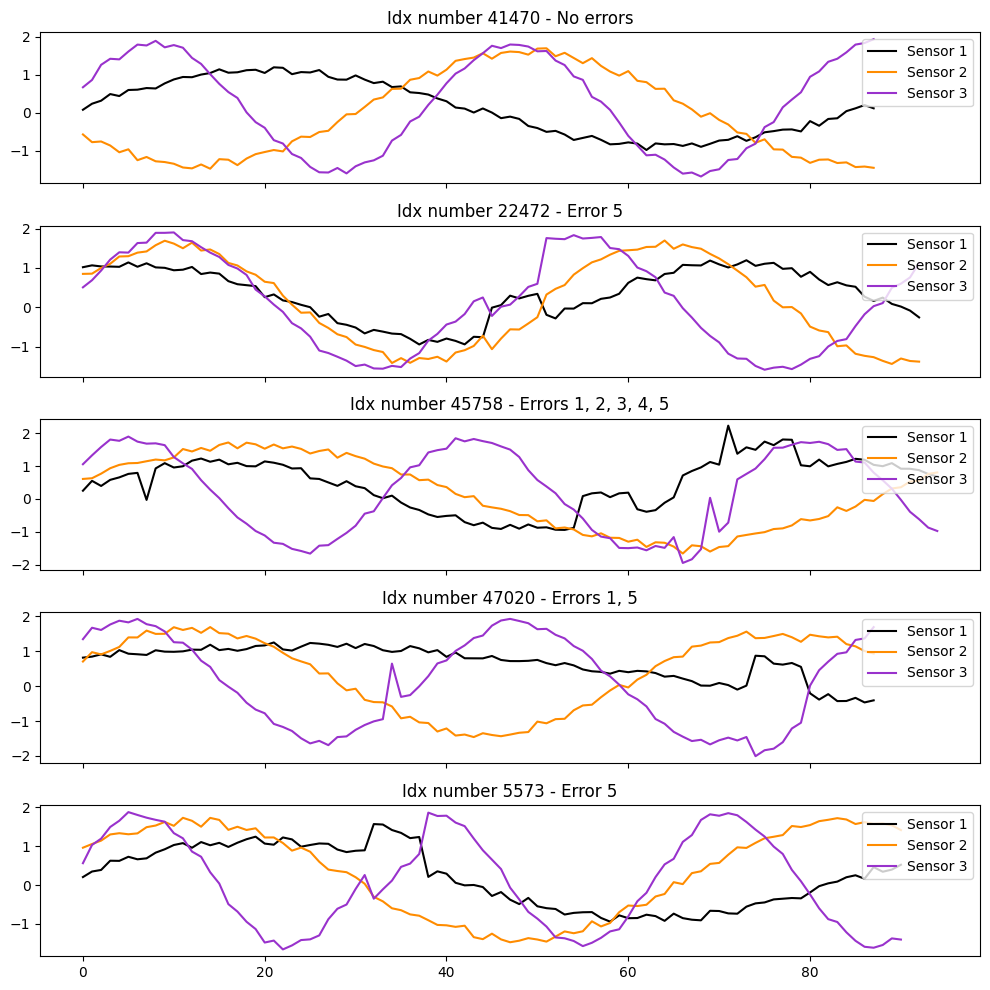

In [ ]:
sensor_plotter(xl, yl, 5)

<p><strong>Describe the data</strong>:
types of functions, different types of errors that you can identify, etc...</p>

<p>You can see how the data in each array contains information from three sensors and these represent sinusoidal wave functions with different amplitudes and frequencies. In addition, the data oscillates in the range of approximately -2 to 2, if all the sensors are taken into account as a whole. You can also see that each array with the sensor readings has a different length, that is, some arrays are longer than others.</p>

<p>In cases where there are errors, it is observed that there can be different types of errors. Thus, the following situations can be identified:
<ul>
<li> Vertical translations of groups of data towards positive or negative values.
<li> Vertical displacement of a single point towards negative or positive values.
<li> The errors occur in a single sensor for an instant of time.
<li> Errors occur in more than one sensor at the same time.
<li> Errors occur in more than one sensor at different times.
</ul>
</p>

## 1.3 Statistics about the data

### Converting labels from booleans to numerics
A <code>map</code> function will be applied that will iterate through all the arrays in the list *yl* and transform the <code>False</code> to 0 and the <code>True</code> to 1.

In [5]:
yl_num = list(map(lambda arr: np.array([0 if x == False else 1 for x in arr]), yl))
yl_num[20]

array([0, 1, 1, 0, 0])

### Probability of occurrence of each type of error and histogram for the class with the lowest probability of occurrence
A function is created that calculates the probability of occurrence of each error by counting how many errors of each type appear in total and dividing by the total number of accounts.

In [232]:
def calculate_error_probabilities(arrays_list: list[np.ndarray]) -> list:
    """
    Calculates the probability of each error to occur and
    returns a list with the probabilities of each error
    using the same index convention.
    """
    # Transpose the arrays so that we can iterate over columns instead of rows
    arrays_T = np.array(arrays_list).T
    # Count the number of errors in each column
    error_counts = [sum(column) for column in arrays_T]
    # Calculate the probabilities by dividing the counts by the number of arrays
    error_probabilities = [count / len(arrays_list) for count in error_counts]
    return error_probabilities


A list will be displayed where the probability of each error occurring has been assigned to the same index as the error, that is, error 1 appears at index 0 and, therefore, its probability will also appear at index 0 in the <code>error_probs</code> list.

In [ ]:
error_probs = calculate_error_probabilities(yl_num)
print("The probabilities of each error occurring are:", error_probs)

Les probabilitats d'aparició de cada error són: [0.1783259619178139, 0.26935775244502586, 0.10191241512489878, 0.32681326439502484, 0.45816981249610667]


Next, a function will be created that will represent a histogram with the sensor values, as a whole and separated by sensors.

In [ ]:
def plot_sensor_histogram(xl: list[np.ndarray], yl: list[np.ndarray], error_probabilities: list) -> None:
	"""
	Selects the elements of yl that have a 1 in the same index of error_probabilities
	with the lowest value. Then, uses these indices to filter xl and plots the
	histogram of the values.
	"""
	# Find the index of the element with minimum value in error_probabilities
	min_index = np.argmin(error_probabilities)

	# Select the indices of yl elements with 1 at min_index
	filtered_y_indices = [i for i, arr in enumerate(yl) if arr[min_index] == 1]

	# Select the elements from xl using filtered_y indices
	filtered_x = [xl[i] for i in filtered_y_indices]

	# Split the elements of each array index and save them into separate lists
	sensor_1 = []
	sensor_2 = []
	sensor_3 = []
	for array in filtered_x:
	sensor_1 += list(array[:, 0])
	sensor_2 += list(array[:, 1])
	sensor_3 += list(array[:, 2])

	# Combine all lists into one
	sensors = sensor_1 + sensor_2 + sensor_3

	# Plot the distribution of filtered_x
	_, ax = plt.subplots(1, 2, figsize=(15, 5))
	ax[0].hist(sensor_1, color='blue', bins=100, alpha=0.5, label='Sensor 1')
	ax[0].hist(sensor_2, color='red', bins=100, alpha=0.5, label='Sensor 2')
	ax[0].hist(sensor_3, color='green', bins=100, alpha=0.5, label='Sensor 3')
	ax[1].hist(sensors, color='black', bins=100, alpha=0.5)
	ax[0].set_title(f"Histogram for each sensor for error {min_index+1} (Index {min_index})", fontsize=16)
	ax[0].legend(loc='best', fontsize=12)
	ax[1].set_title(f"Histogram for all sensors for error {min_index+1} (Index {min_index})", fontsize=16)
	for i in range(2):
	ax[i].set_xlabel("Sensor values", fontsize=14)
	ax[i].set_ylabel("Counts", fontsize=14)
	ax[i].tick_params(labelsize=12)
	plt.show()

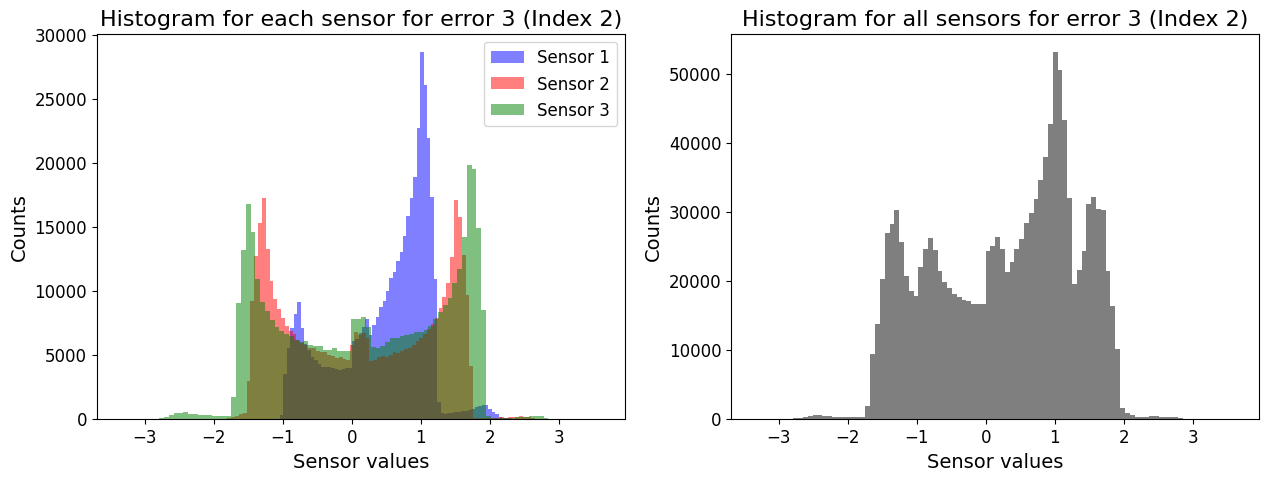

In [ ]:
plot_sensor_histogram(xl, yl_num, error_probs)

Next, a function will be created that will represent a histogram with the values ​​of the sensors, as a whole and separated by sensors. Finally, a function is created that represents the count of errors for the type of error with the lowest probability.

In [235]:
def plot_class_histogram(y_arrays: list[np.ndarray], error_probabilities: list) -> None:
	"""
	Selects the elements of yl_arrays that have a 1 in the same index of error_probabilities
	with the lowest value. Then, uses these indices to filter yl and plots the
	histogram of the values.
	"""
	# Find the index of the element with minimum value in error_probabilities
	min_index = np.argmin(error_probabilities)

	# Select the elements of each array where the index matches with min_index
	selected_elements = np.array([arr[min_index] for arr in y_arrays], dtype=np.uint8)

	# Plot the histogram
	plt.hist(selected_elements, bins=np.arange(3) - 0.5, color='darkgreen', align='mid', alpha=0.7)
	plt.title(f"Histogram for the class with minimum value (Error {min_index+1}, Índex {min_index})", fontsize=16)
	plt.ylabel("Counts", fontsize=14)
	plt.tick_params(labelsize=12)
	plt.xticks([0, 1], ['False', 'True'])
	plt.show()

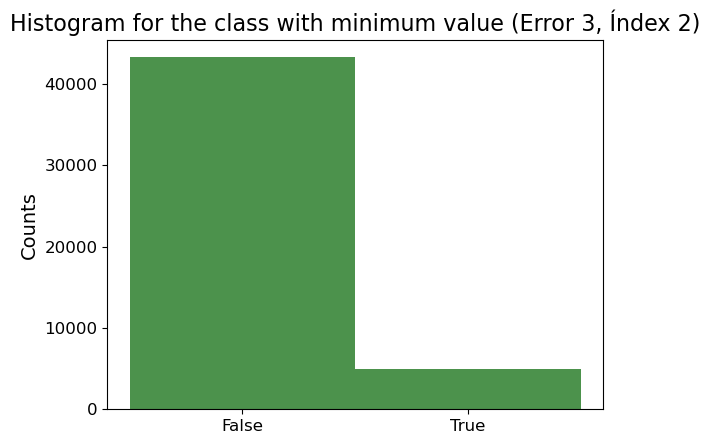

In [236]:
plot_class_histogram(yl_num, error_probs)


### Average, maximum and minimum length of sensor readings and histogram for lengths

A function will be created that allows calculating the average, maximum and minimum length of each reading (array) in the list *xl*.

In [8]:
def calc_lengths(arrays: np.ndarray) -> tuple[float, int, int]:
    """
    Calculates the average, minimum and maximum lengths for a list or arrays.
    """
    lengths = [len(a) for a in arrays]
    avg_length = round(sum(lengths) / len(lengths), 2)
    min_length = min(lengths)
    max_length = max(lengths)
    return avg_length, min_length, max_length

In [ ]:
avg_length, min_length, max_length = calc_lengths(xl)
print(f"The average length is {avg_length}, the minimum is {min_length} and the maximum is {max_length}.")

La longitud mitja és 89.5, la mínima és 78 i la màxima és 101.


Next, a function is created that represents the distribution of the lengths of the different arrays in the list *xl*.

In [238]:
def plot_lengths_hist(arrays: np.ndarray) -> list:
    """
    Plots the distribution of lengths for a list of arrays.
    """
    lengths = [len(a) for a in arrays]   
    plt.hist(lengths, bins=50)
    plt.title("Histograma de longituds")
    plt.xlabel("Longitud")
    plt.ylabel("Frequència")
    plt.show()
    return lengths

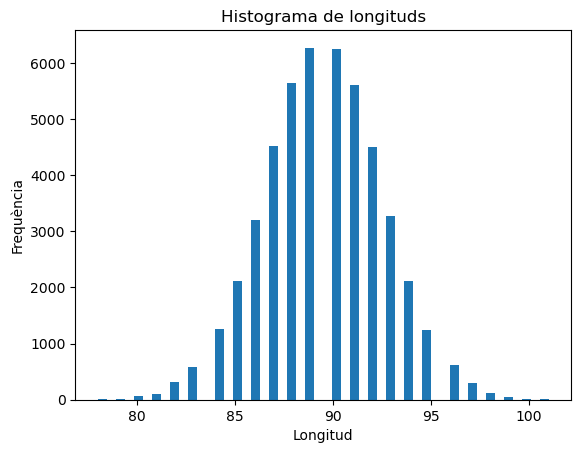

In [239]:
lengths = plot_lengths_hist(xl)

The distribution appears normal, but to check this, an artificially normal distribution can be generated where the mean and standard deviation are those found for the lengths. This will allow us to visually check whether the lengths really follow a normal distribution or not.

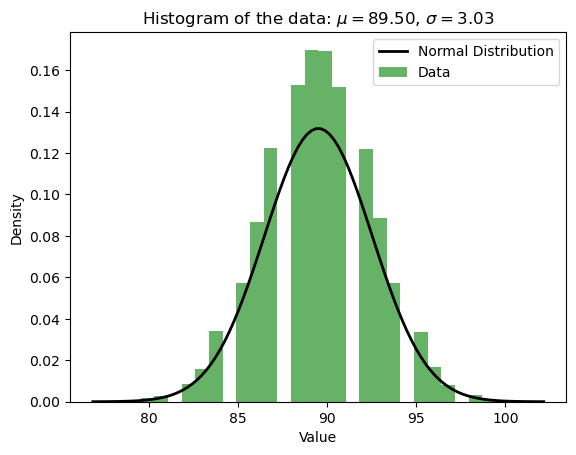

In [240]:
from scipy.stats import norm
# Fit a normal distribution to the data
mu, std = norm.fit(lengths)

# Plot the histogram of the data
plt.hist(lengths, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', lw=2)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(r'Histogram of the data: $\mu=%.2f$, $\sigma=%.2f$' % (mu, std))
plt.legend(['Normal Distribution', 'Data'])
plt.show()

<p><strong>Comments:</strong></p>
<p>The probabilities of occurrence of errors 1 and 3 are less than 20%, while errors 2, 4 and 5 have probabilities greater than 20%. The error with the least probability is 3 with 10%, while the error with the most probability is 5 with 46%.</p>
<p> The distributions of the sensor data for error 3 show how there are few values ​​close to the mean while the tails have more accumulation of values. This is due to the type of function that the data represents, which is sinusoidal. Thus, the slope of the data decreases when reaching the maximum or minimum and that is why there are more values ​​at these points. It can be understood in a similar way to a sigmoid function where values ​​close to 0 or 1 decay more slowly than the values ​​in the middle which change rapidly.</p>
<p>In contrast, the distribution of class values ​​in <code>True</code> or <code>False</code> indicates that there are many more values ​​that belong to <code>False</code>. Therefore, this class is unbalanced and, as expected, the rest of the classes will also be unbalanced in the proportion of the probabilities calculated before, that is, ~0.18 (Error 1), 0.27 (Error 2), 0.1 (Error 3), 0.33 (Error 4) and 0.46 (Error 5).</p>
<p>Finally, it can be seen that the average length of the arrays is approximately 90 (89.5), the minimum is 78 and the maximum is 101. The lengths follow a distribution that closely resembles a normal distribution centered at 89.5 and with a standard deviation of 3. In fact, the normal distribution generated in the previous figure shows a very good fit of the length data to a normal one.</p>

## 1.4 Standardizing the length of the data

### Data transformation

In [27]:
def process_xl_mean_vals(xl: list[np.ndarray]) -> list[np.ndarray]:
    """
    Preprocesses the xl list according to the criteria defined above.
    """
    # Calculate the average length of arrays
    avg_length = np.mean([arr.shape[0] for arr in xl])
    
    # Process each array in the list
    new_xl = []
    for arr in xl:
        if arr.shape[0] > avg_length:
            # If the length of the array is larger than the average, cut the array
            arr = arr[:int(round(avg_length, 0))]
        elif arr.shape[0] < avg_length:
            # If the length of the array is shorter than the average, add the mean values of each sensor to complete it
            missing_rows = int(round(avg_length, 0) - arr.shape[0])
            missing_data = np.tile(np.mean(arr, axis=0), (missing_rows, 1))
            arr = np.concatenate((missing_data, arr), axis=0)
        # Add the processed array to the new list
        new_xl.append(arr)
        
    return new_xl

In [31]:
new_xl_mean_vals = process_xl_mean_vals(xl)

The <code>calc_lengths</code> function is used to calculate that the lengths have been reassigned correctly.

In [9]:
calc_lengths(new_xl_mean_vals)

(90.0, 90, 90)

You can see how the array *xl* has been transformed correctly and now the average, maximum and minimum lengths are the same, that is, 90.

### Data representation

In [ ]:
print(f"The original lengths of indices 27232 and 32266 are {len(xl[27232])} and {len(xl[32266])}, respectively.")

Les longituds originals dels índexs 27232 i 32266 són 84 i 95, respectivament.


In [ ]:
print(f"The new lengths of indices 27232 and 32266 are {len(new_xl_mean_vals[27232])} and {len(new_xl_mean_vals[32266])}, respectively.")

Les longituds noves dels índexs 27232 i 32266 són 90 i 90, respectivament.


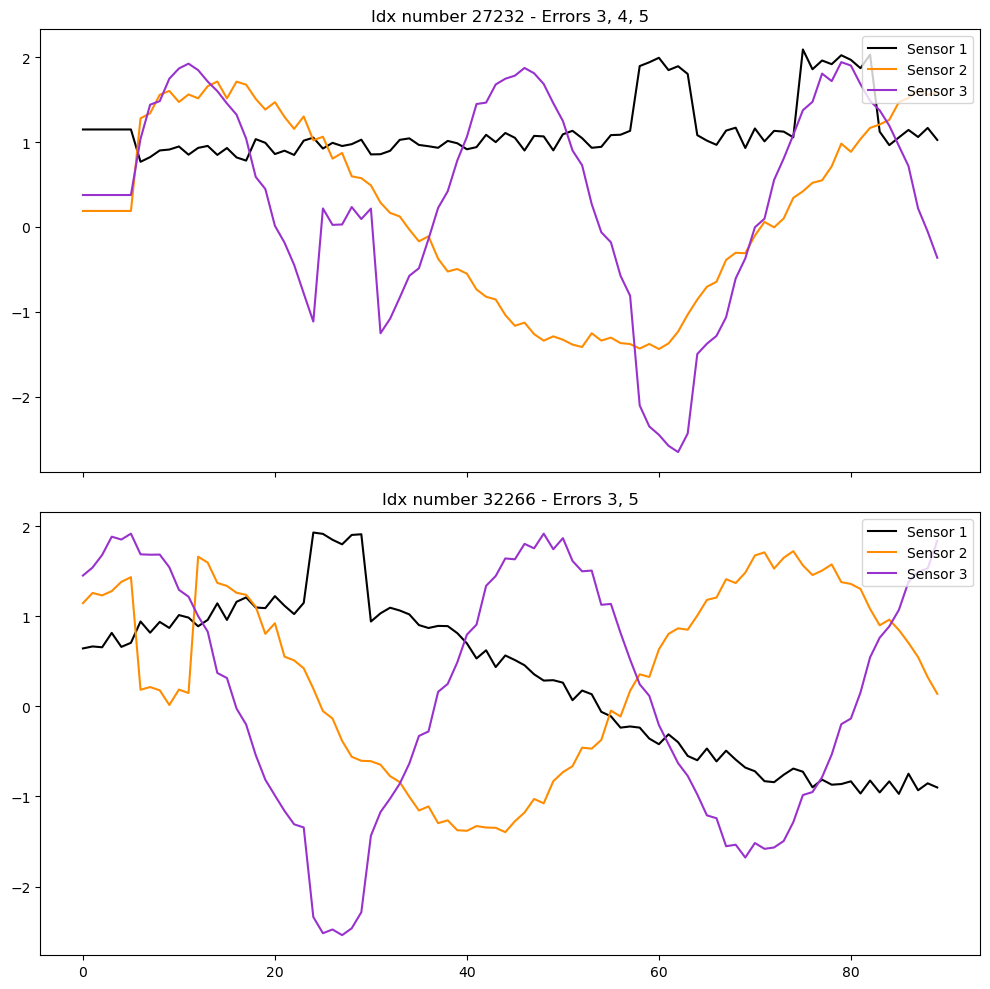

In [28]:
sensor_plotter(new_xl_mean_vals, yl, 2)

<p><strong>Comment on what kind of problems this process can cause</strong>. Would you propose another method to standardize the data?</p>
<p>You can see how the data transformation has been done correctly since it started from arrays with an average length of 89.5, a minimum of 78 and a maximum of 101 and after the transformation the average, minimum and maximum values ​​are all 90.</p>
<p>You can also see how the representation of the data with a length value higher than the average is cut off at 90, while those with a lower length are filled with the average.
</p>
<p>However, it is clear that this method is not the best since it will work well for sensors where the wave oscillation at the point where the measurement ends is close to the average. However, as seen in the figure below, in sensors where the previous point is far from the average, there is a significant jump between the values.</p>
<p>A possible solution to improve the quality of the uniformization of the array lengths would consist of cutting the arrays at the minimum value. In this case, information from the sensors would be lost, but the wave functions would not make these abrupt jumps. However, this would not be the best solution, since we would be losing vital information that could help make more accurate predictions.</p>
<p> A second option would be to use the Fourier transform to extract the frequency of the data from each sensor and then extrapolate the values ​​of the function to the maximum length following the periodicity of the wave. This option would work much better for this case since the sensor data are sine/cosine type functions and have a periodicity. [1, 2]</p>
<p>Finally, the time series of the sensors could also be decomposed into their components (general trend, seasonality, cyclical and random variations). [3] Then, for each component, models could be created to generate future predictions of each component and combine them to obtain the original representation again. This would allow to complete those series with a length less than the maximum. In this case, methods such as ARIMA (<i>autoregressive integrated moving average</i>) could be used, which aims to model the autocorrelation and stationarity of the data of a time series with the aim of finding patterns and making future predictions, [4, 5] or using recurrent networks that also allow to reconstruct the shape of the time series based on the relationships of the data in previous times to make predictions. [6, 7]</p>

<p><strong>References:</strong>
<ul>
<li> [1] https://docs.scipy.org/doc/scipy/tutorial/fft.html
<li> [2] https://stackoverflow.com/questions/4479463/using-fourier-analysis-for-time-series-prediction
<li> [3] Jordi Casas Roma, <i>Introduction to Time Series Analysis</i>, UOC (2023).
<li> [4] https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
<li> [5] https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average
<li> [6] Toni Lozano Bagén, <i>Recurrent Neural Networks</i>, UOC (2023).
<li> [7] Aurélien Géron, <i>Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow</i>, 3rd. Ed, O'Reilly (2023).
</ul></p>

In [ ]:
print("The dimensions of the array list 'xl' are:", len(new_xl_mean_vals))
print("Each array of 'new_xl_mean_vals' has dimensions:", new_xl_mean_vals[0].shape)
print("The dimensions of the array list 'yl' are:", len(yl_num))
print("Each array of 'new_xl_mean_vals' has dimensions:", yl_num[0].shape)

Les dimensions de la llista d'arrays 'xl' és: 48159
Cada array de 'new_xl_mean_vals' té dimensions: (90, 3)
Les dimensions de la llista d'arrays 'yl' és: 48159
Cada array de 'new_xl_mean_vals' té dimensions: (5,)


## 1.5 Split data for classification

In [25]:
def train_val_test_split(
	xl: list[np.ndarray], yl: list[np.ndarray], shuffle: bool,
	train_size: float, val_size: float, test_size: float, 
	random_state: int = None
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
	"""
	Splits the arrays into train, validation and test sets using the ratios
	provided and shuffles them. Also, transforms the data into tensors and
	creates batches to be used during training and testing.
	"""
	# Check that the sizes sum 1
	assert train_size + val_size + test_size == 1.0

	# Split the lists of arrays into train, val and test based on the input sizes
	train_len = int(len(xl) * train_size)
	val_len = int(len(xl) * val_size)
	test_len = int(len(xl) * test_size)

	X_train, y_train = np.array(xl[:train_len]), np.array(yl[:train_len])
	X_val, y_val = np.array(xl[train_len:train_len+val_len]), np.array(yl[train_len:train_len+val_len])
	X_test, y_test = np.array(xl[-test_len:]), np.array(yl[-test_len:])

	# Shuffle the data by permuting the indices of each array
	if shuffle:
		if random_state is not None:
			np.random.seed(random_state)
		train_idx = np.random.permutation(len(X_train))
		val_idx = np.random.permutation(len(X_val))
		test_idx = np.random.permutation(len(X_test))
		X_train, y_train = X_train[train_idx], y_train[train_idx]
		X_val, y_val = X_val[val_idx], y_val[val_idx]
		X_test, y_test = X_test[test_idx], y_test[test_idx]

	return X_train, y_train, X_val, y_val, X_test, y_test

In [32]:
X_train, y_train, X_val, y_val, X_test, y_test = \
    train_val_test_split(xl=new_xl_mean_vals, yl=yl_num, shuffle=True,
                        train_size=0.8, val_size=0.1, test_size=0.1, 
                        random_state=42)

In [ ]:
print("The dimensions of the dataset X_train are:", X_train.shape)
print("The dimensions of the dataset y_train are:", y_train.shape)
print("\nThe dimensions of the dataset X_val are:", X_val.shape)
print("The dimensions of the dataset y_val are:", y_val.shape)
print("\nThe dimensions of the dataset X_test are:", X_test.shape)
print("The dimensions of the dataset y_test are:", y_test.shape)

Les dimensions del dataset X_train són: (38527, 90, 3)
Les dimensions del dataset y_train són: (38527, 5)

Les dimensions del dataset X_val són: (4815, 90, 3)
Les dimensions del dataset y_val són: (4815, 5)

Les dimensions del dataset X_test són: (4815, 90, 3)
Les dimensions del dataset y_test són: (4815, 5)


In [ ]:
print("The length of the train dataset is:", len(X_train))
print("The length of the validation dataset is:", len(X_val))
print("The length of the test dataset is:", len(X_test))

La longitud del dataset train és: 38527
La longitud del dataset validation és: 4815
La longitud del dataset test és: 4815


The result of applying the previous function generates three datasets (*train, validation, test*) separated into components *X*, which contains the sensor measurements and with dimensions (*length*, 90, 3), and *y*, which contains the label information and with dimensions (*length*, 5)

You can see how the arrays have been separated correctly, since the dimensions of the training set correspond to 80% of those of the original dataset (48159 x 0.8 = 38527) and the validation and test sets with 10%.

Next, the shuffle result is checked for any array:

In [246]:
yl_num[20]

array([0, 1, 1, 0, 0])

In [247]:
y_train[20]

array([1, 1, 0, 1, 1])

You can also see how the shuffle is correct, since any array in the dataset *yl_num* is different from the array with the same index for *y_train*. If there had been no shuffle, they should match.

# 2. Classification (3 points)

The first step will be to define the dimensions of the input data to the models:

In [ ]:
print("Each array of 'sensor_data' has dimensions:", X_train[0].shape)
n_sensors = X_train[0].shape[1]
print(f"So, we have {n_sensors} sensors.")

print("\nThe number of classes is:", y_train[0].shape)
n_classes = y_train[0].shape[0]
print(f"So, we have {n_classes} error types")

Cada array de 'sensor_data' té dimensions: (90, 3)
Per tant, tenim 3 sensors.

El nombre de classes és: (5,)
Per tant, tenim 5 tipus d'errors


## 2.1 Callbacks

Once we have the data prepared and we better understand the data set we have, we can start testing different architectures for classifying error types.

In [4]:
class TimerCallback(Callback):
    """
    Custom callback to track the time used for training.
    Source: https://keras.io/guides/writing_your_own_callbacks/
    """
    def __init__(self):
        super().__init__()
        # Initialize the variables to store the results
        self.epoch_train_times = []
        self.epoch_times = []
        self.total_time = None

    def on_train_begin(self, logs=None):
        # Initialize the timer to record the training time
        self.start_time = timer()
        
    def on_epoch_begin(self, epoch, logs=None):
        # Initialize the timer to record the epoch time
        self.epoch_start_time = timer()

    def on_epoch_end(self, epoch, logs=None):
        # Get the elapsed train and epoch times for each epoch
        elapsed_train_time = timer() - self.start_time
        elapsed_epoch_time = timer() - self.epoch_start_time
        # Save the results to the corresponding lists
        self.epoch_train_times.append(elapsed_train_time)
        self.epoch_times.append(elapsed_epoch_time)
        
    def on_train_end(self, logs=None):
        # Record the total time
        self.total_time = timer() - self.start_time
        print(f"Total training time: {self.total_time:.2f} seconds")
        

Additionally, we will use the following class to visualize metrics during model _fit_:

In [ ]:
class PlotLearning(Callback):
    """
    Callback para plotear las métricas durante el entrenamiento.
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                  

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

## 2.2 SimpleRNN Layer

### Justification of the activation function, loss, metrics and learning rate

Before defining the model, it will be necessary to understand which activation function, loss and metrics should be used.

First, this is a multi-label classification problem because we have different types of errors and each one takes the value 0 or 1 independently of the rest, that is, they are not mutually exclusive. Therefore, we can think of each label as a binary classification problem by itself. Therefore, the *sigmoid* activation function has been chosen, since it returns a probability function between 0 and 1 for each label. (pp. 239, 413, 422 and 705 of [1])

Second, the *binary_crossentropy* has been chosen because it is useful for the type of classification of the dataset. *binary_crossentropy* calculates the loss for each label and then sums all labels, returning the total loss. (p. 422 of [1] and [2])

Regarding the metrics, the *weighted F1-score* and *BinaryAccuracy* have been chosen. *BinaryAccuracy* has been chosen because it is the appropriate metric for multi-label binary classification where each class is considered as a separate binary classification problem. (p. 239 of [1]) However, it should be noted that the accuracy only takes into account the values ​​classified correctly with respect to the total. In this case, some of the labels are quite unbalanced with a majority class quite overrepresented as shown in exercise 1 when the probabilities of occurrence of each error have been calculated. Therefore, accuracy only indicates the fact that the model is able to predict the majority label very well, but this may not be useful in certain applications. For this reason, it has been decided to also evaluate the *weighted F1-score* which is a suitable metric for binary classification when there are unbalanced classes, since it takes into account both correctly classified and incorrectly classified values. [3-5]

Finally, the same initial *learning_rate* has been chosen for all models. In this way, it will be much easier to compare the behavior between them, since otherwise, the default values ​​would be used.

**References:**

[1] Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow*, 3rd. Ed, O'Reilly (2023).

[2] https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451

[3] https://towardsdatascience.com/the-f1-score-bec2bbc38aa6

[4] https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score

[5] https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryAccuracy

In [7]:
from tensorflow_addons.metrics import F1Score

In [8]:
def simpleRNN_model(
	input_shape: tuple[int, int], num_classes: int, units: int, lr: float = 0.001
) -> Model:
	"""
	Creates a SimpleRNN model for classification and compiles it.

	The code is based on the implementations found in:
	- https://keras.io/api/layers/recurrent_layers/simple_rnn/
	- https://github.com/jcasasr/Libro-Deep-Learning
	- Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
	- Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
	"""
	# Create the model with SimpleRNN and dense layers
	inputs = Input(shape=input_shape)
	x = SimpleRNN(units=units)(inputs)
	outputs = Dense(units=num_classes, activation='sigmoid')(x)
	simple_RNN = Model(inputs=inputs, outputs=outputs)

	# Compile the model using Adam as the optimizer and the binary crossentropy loss
	simple_RNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                    loss='binary_crossentropy',
					metrics=[
						'binary_accuracy',
						F1Score(num_classes=num_classes, average='weighted')
					])
	return simple_RNN


In [61]:
simple_RNN = simpleRNN_model(input_shape=(90, 3), num_classes=5, units=128, lr=0.001)
simple_RNN.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 90, 3)]           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               16896     
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                                 
Total params: 17,541
Trainable params: 17,541
Non-trainable params: 0
_________________________________________________________________


#### Training

In [9]:
def train_model(
	model: Sequential, X_train: np.ndarray, y_train: np.ndarray, 
	X_val: np.ndarray, y_val: np.ndarray, epochs: int = 100, 
	batch_size: int = 256, patience: int = 5, showLR: bool = False, 
	checkpoint_filepath: str = 'placeholder.h5', reduce_learning_rate: bool = True
) -> tuple[tf.keras.callbacks.History, TimerCallback]:
	"""
	Trains a model using the parameters specified and different callbacks as
	described in the exercise.

	The code is based on the implementations found in:
	- https://github.com/jcasasr/Libro-Deep-Learning
	- Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
	- Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
	"""
	# Setup the callbacks
	timer_cb = TimerCallback()
	plot_losses = PlotLearning(showLR=showLR)
	early_stop = EarlyStopping(monitor='val_loss', patience=patience)
	reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=patience)
	checkpoint = tf.keras.callbacks.ModelCheckpoint(
		filepath=checkpoint_filepath,
		save_weights_only=True,
		monitor='val_binary_accuracy',
		mode='max',
		save_best_only=True
	)

	# Set the callbacks depending on the value of reduce_learning_rate
	callbacks_list = [timer_cb, plot_losses, early_stop, reduce_lr, checkpoint]
	if reduce_learning_rate is False:
		callbacks_list = [timer_cb, plot_losses, early_stop, checkpoint]

	# Train the model with the specified callbacks
	history = model.fit(X_train, y_train, 
		validation_data=(X_val, y_val), 
		epochs=epochs, 
		batch_size=batch_size,
		callbacks=callbacks_list)

	return history, timer_cb

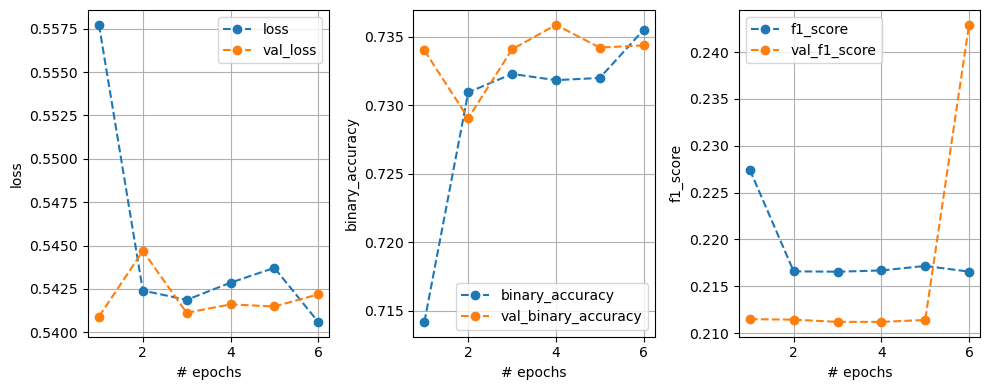

151/151 [==============================] - 8s 51ms/step - loss: 0.5406 - binary_accuracy: 0.7355 - f1_score: 0.2166 - val_loss: 0.5422 - val_binary_accuracy: 0.7344 - val_f1_score: 0.2429 - lr: 0.0010
Total training time: 49.10 seconds


In [63]:
checkpoint_simpleRNN = f"{home}/saved_results/simple_RNN.h5"
trained_simpleRNN, timer_simpleRNN = train_model(simple_RNN, X_train, y_train, X_val, y_val,
                                epochs=100, batch_size=256, patience=5,
                                showLR=False, checkpoint_filepath=checkpoint_simpleRNN,
                                reduce_learning_rate=True)

### Evaluation of accuracy and loss with the test set

In [64]:
test_loss_simpleRNN, test_acc_simpleRNN, test_f1_simpleRNN = simple_RNN.evaluate(X_test, y_test)

151/151 [==============================] - 2s 12ms/step - loss: 0.5466 - binary_accuracy: 0.7305 - f1_score: 0.2497


### Representation of time for each epoch and calculation of total training time

In [19]:
def plot_time_per_epoch(timer_cb: TimerCallback):
    """
    Plots the time spent per epoch and the cumulative time.
    Expects a TimerCallback object as input.
    """
    # Get the epoch and total times and calculate the average epoch time
    epoch_train_times = timer_cb.epoch_train_times
    epoch_times = timer_cb.epoch_times
    total_time = timer_cb.total_time
    avg_epoch_time = np.mean(epoch_times)
    
    # Create a range of epochs
    epochs = range(1, len(epoch_times) + 1)
    
    fig, ax1 = plt.subplots()
    # Plot the time for each epoch
    ax1.set_xlabel("Epoch", fontsize=14)
    ax1.set_ylabel("Time per epoch (s)", fontsize=14)
    ax1.bar(epochs, epoch_times, label="Time per epoch", color='black', alpha=0.5)
    ax1.tick_params(axis='both', labelsize=12)
    
    # Plot the average epoch time 
    ax1.hlines(avg_epoch_time, epochs[0], epochs[-1], color='steelblue', linestyles='dashed')
    ax1.text(epochs[0], avg_epoch_time + 0.2, f"Avg. time per epoch: {avg_epoch_time:.2f} s")

    # Plot the cumulative time (train time)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Elapsed train time (s)", fontsize=14)
    ax2.plot(epochs, epoch_train_times, label="Elapsed train time per epoch", color='crimson', alpha=0.7, marker='.')
    ax2.tick_params(axis='y', labelsize=12)
    
    # Plot the total train time
    ax2.hlines(total_time, epochs[0], epochs[-1], color='darkgreen', linestyles='dashed')
    ax2.text(epochs[0], total_time + 0.2, f"Total train time: {total_time:.2f} s")

    ax1.set_title("Time per epoch and cumulative time", fontsize=16)
    fig.legend(loc='lower right', bbox_to_anchor=(0.9, 0.1), fontsize=12)
    plt.show()


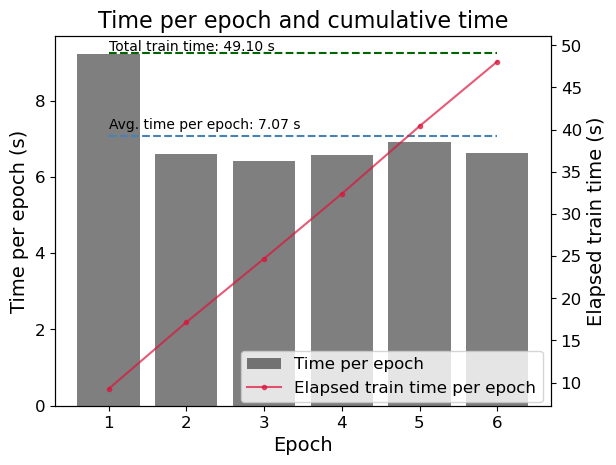

In [67]:
plot_time_per_epoch(timer_simpleRNN)

## 2.3 GRU layer

### Model definition

In [10]:
def simpleGRU_model(
    input_shape: tuple[int, int], num_classes: int, units: int, lr: float = 0.001
) -> Model:
	"""
	Creates a simpleGRU model with one layer for classification and compiles it.

	The code is based on the implementations found in:
		- https://keras.io/api/layers/recurrent_layers/gru/
		- https://github.com/jcasasr/Libro-Deep-Learning
		- Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
		- Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
	"""
	# Create the sequential model with GRU and dense layers
	inputs = Input(shape=input_shape)
	x = GRU(units=units, activation='tanh')(inputs)
	outputs = Dense(units=num_classes, activation='sigmoid')(x)
	simple_GRU = Model(inputs=inputs, outputs=outputs)
	
	# Compile the model using Adam as the optimizer and the binary crossentropy loss
	simple_GRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                    loss='binary_crossentropy',
					metrics=[
						'binary_accuracy',
						F1Score(num_classes=num_classes, average='weighted')
					])

	return simple_GRU

In [11]:
simple_GRU = simpleGRU_model(input_shape=(90, 3), num_classes=5, units=64, lr=0.001)
simple_GRU.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 3)]           0         
                                                                 
 gru (GRU)                   (None, 64)                13248     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 13,573
Trainable params: 13,573
Non-trainable params: 0
_________________________________________________________________


### Training

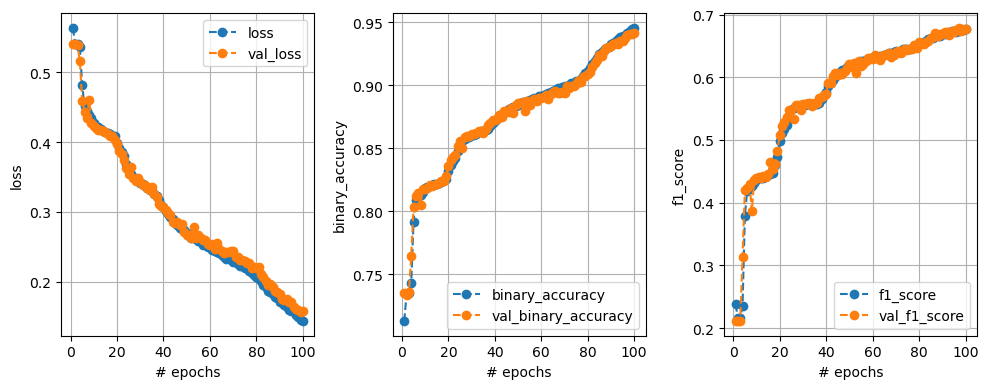

151/151 [==============================] - 3s 17ms/step - loss: 0.1439 - binary_accuracy: 0.9456 - f1_score: 0.6777 - val_loss: 0.1580 - val_binary_accuracy: 0.9413 - val_f1_score: 0.6766 - lr: 0.0010
Total training time: 268.20 seconds


In [70]:
checkpoint_simpleGRU = f"{home}/saved_results/simple_GRU.h5"
trained_simpleGRU, timer_simpleGRU = train_model(simple_GRU, X_train, y_train, X_val, y_val,
                                epochs=100, batch_size=256, patience=5,
                                showLR=False, checkpoint_filepath=checkpoint_simpleGRU,
                                reduce_learning_rate=True)

### Evaluation of accuracy and loss with the test set

In [71]:
test_loss_simpleGRU, test_acc_simpleGRU, test_f1_simpleGRU = simple_GRU.evaluate(X_test, y_test)

151/151 [==============================] - 1s 5ms/step - loss: 0.1531 - binary_accuracy: 0.9423 - f1_score: 0.6707


### Representation of time for each epoch and calculation of total training time

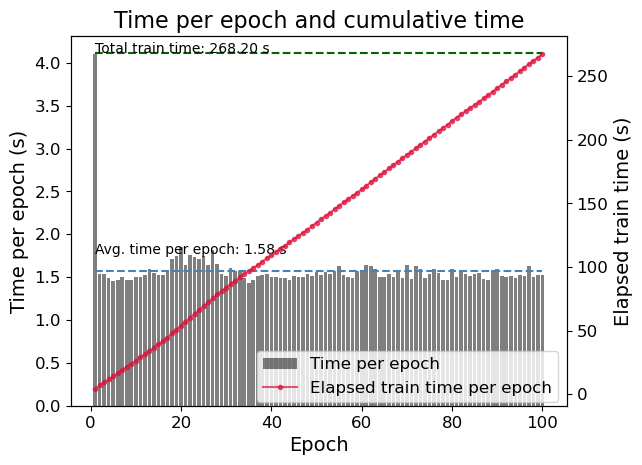

In [72]:
plot_time_per_epoch(timer_simpleGRU)

<p><strong>Comments:</strong></p>
<p>It can be seen that using the <i>SimpleRNN</i> network completes the training in about 50 seconds with an average of 1.6 seconds per epoch. The number of trained parameters is 17,541. It is also observed that the loss does not decrease practically and, therefore, the training ends in 6 epochs. The final loss values ​​are 0.5406 and 0.5422 for training and validation, respectively. Regarding accuracy and F1-Score, the maximum training values ​​are 0.7355 and 0.2166, while for the validation set they are 0.7344 and 0.2429. Finally, the evaluation of the results on the test set returns values ​​of 0.5466, 0.7305 and 0.2497 for the loss, accuracy and F1-Score, respectively. The clear difference between the accuracy and the F1-Score is due to the fact that we are dealing with a multi-label classification problem where some of the labels are quite unbalanced with a majority class quite represented as seen in exercise 1. Therefore, the accuracy only indicates the fact that the model is able to predict the majority label very well. On the other hand, the F1-Score is a metric that takes into account the ratio between the correctly and incorrectly classified values, allowing a better representation of the quality of the model. (p. 239 of [1], [2, 3-5])</p>
<p>The <i>GRU</i> network finishes training in about 270 seconds with an average of 1.6 seconds per epoch. The number of trained parameters is 13,573. It is also observed how the loss decreases from an initial value of approximately 0.6 to 0.15 and the training ends in 100 epochs. The final loss values ​​are 0.1439 and 0.158 for training and validation, respectively. Regarding the accuracy and F1-Score the maximum training values ​​are 0.9456 and 0.6777, while for the validation set they are 0.9413 and 0.6766. Finally, the evaluation of the results on the test set returns values ​​of 0.1531, 0.9423 and 0.6707 for the loss, accuracy and F1-Score, respectively.</p>

<p>These results indicate that the model with the <i>SimpleRNN</i> network is not good for the classification of sensor errors, since as mentioned before the values ​​of loss, accuracy and F1-Score do not show an improvement over time, while the results obtained with the <i>GRU with one layer</i> network denote a significant improvement in the quality of the model. This indicates that the <i>GRU with one layer</i> network is very suitable for classification with very low loss and very good values ​​of accuracy and F1-Score. Therefore, it can be concluded that there is a significant improvement in performance with the use of the <i>GRU with one layer</i> network.</p>

<p>The reason for the good performance of the <i>GRU</i> network may be due to several reasons. First, the <i>SimpleRNN</i> network consists of a fully connected layer where the results of one timestep are passed to the next. In addition, the problems of vanishing and exploding gradients are more likely to appear, making it difficult for the model to learn long-term dependencies. (pp. 9-13 of [2]) In contrast, the <i>GRU with one layer</i> network is formed by gating mechanisms that allow the network to update and reset the <i>hidden states</i> selectively, which facilitates the learning of long-term relationships. Furthermore, the memory mechanism is more complex, as the network stores or forgets information depending on the current state of the sequence, while the <i>SimpleRNN</i> stores the information directly. (pp. 14-21 of [2], [6], chapters 9.4 and 10.2 of [7])</p>

<p>Regarding the number of parameters, the GRU network has to train fewer (13,573 vs 17,541) and is therefore computationally more efficient than the <i>SimpleRNN</i>. This is due to the gating system mentioned above. (pp. 14-21 of [2], [6], chapters 9.4 and 10.2 of [7]) On the other hand, if we consider the training time. This is much higher for the <i>GRU with one layer</i> network (270 vs 50 seconds). However, it is clear that the <i>SimpleRNN</i> network has been unable to learn and the use of <i>EarlyStopping</i> has ended the training after 5 epochs as it did not see an improvement in the loss. Therefore, this short time has been obtained. If <i>EarlyStopping</i> had not been used, it is likely that the training time would have exceeded that of the <i>GRU with one layer</i> network.</p>

<p><strong>References:</strong></p>
<ul>
<li> [1] Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow*, 3rd. Ed, O'Reilly (2023).
<li> [2] Toni Lozano Bagén, *Redes Neuronales Recurrentes*, UOC (2023).
<li> [3] https://towardsdatascience.com/the-f1-score-bec2bbc38aa6
<li> [4] https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score
<li> [5] https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryAccuracy
<li> [6] Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, Yoshua Bengio, <i>Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation</i>, arXiv:1406.1078 (2014).
<li> [7] Aston Zhang, Zachary C. Lipton, Mu Li, Alexander J. Smola, <i>Dive into Deep Learning</i>, 2023.
</ul>

### 2.3.1 Increasing the capacity of our model

### Model definition

In [12]:
def twoGRU_model(input_shape: tuple[int, int], num_classes: int, units: int, lr: float) -> Model:
	"""
	Creates a model with two GRU layers for classification and compiles it.

	The code is based on the implementations found in:
		- https://keras.io/api/layers/recurrent_layers/gru/
		- https://github.com/jcasasr/Libro-Deep-Learning
		- Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
		- Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
	"""
	# Create the sequential model with two GRU and a dense layer
	inputs = Input(shape=input_shape)
	x = GRU(units=units, activation='tanh', return_sequences=True)(inputs)
	x = GRU(units=units//2, activation='tanh')(x)
	outputs = Dense(units=num_classes, activation='sigmoid')(x)
	two_gru = Model(inputs=inputs, outputs=outputs)

	# Compile the model using Adam as the optimizer and the binary crossentropy loss
	two_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                    loss='binary_crossentropy',
					metrics=[
						'binary_accuracy',
						F1Score(num_classes=num_classes, average='weighted')
					])

	return two_gru

In [13]:
two_GRU = twoGRU_model(input_shape=(90, 3), num_classes=5, units=64, lr=0.001)
two_GRU.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 90, 3)]           0         
                                                                 
 gru_1 (GRU)                 (None, 90, 64)            13248     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


### Training

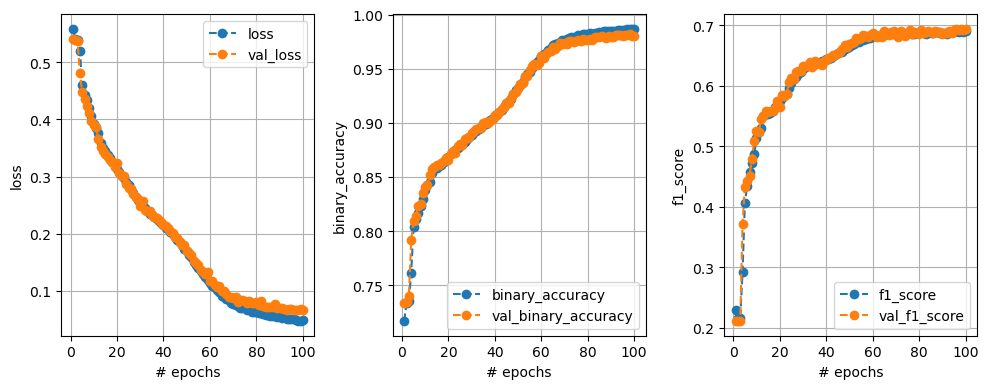

151/151 [==============================] - 3s 22ms/step - loss: 0.0484 - binary_accuracy: 0.9864 - f1_score: 0.6901 - val_loss: 0.0662 - val_binary_accuracy: 0.9805 - val_f1_score: 0.6946 - lr: 0.0010
Total training time: 372.36 seconds


In [75]:
checkpoint_twoGRU = f"{home}/saved_results/two_GRU.h5"

trained_twoGRU, timer_twoGRU = train_model(two_GRU, X_train, y_train, X_val, y_val,
                                epochs=100, batch_size=256, patience=5,
                                showLR=False, checkpoint_filepath=checkpoint_twoGRU,
                                reduce_learning_rate=True)

### Evaluation of accuracy and loss with the test set

In [76]:
test_loss_twoGRU, test_acc_twoGRU, test_f1_twoGRU = two_GRU.evaluate(X_test, y_test)

151/151 [==============================] - 1s 7ms/step - loss: 0.0580 - binary_accuracy: 0.9831 - f1_score: 0.6885


### Representation of time for each epoch and calculation of total training time

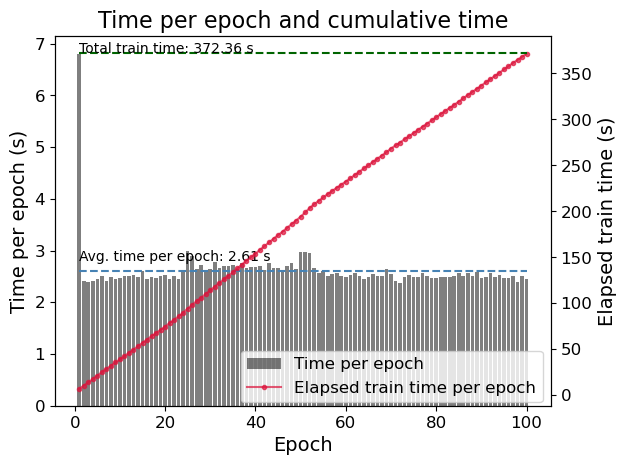

In [77]:
plot_time_per_epoch(timer_twoGRU)

<p><strong>Comments:</strong></p>
<p>Using the <i>GRU with two layers</i> network finishes the training in about 370 seconds with an average of 2.6 seconds per epoch. The number of trained parameters is 22,821, almost double that of the <i>GRU with one layer</i> network 13,573. It is also observed how the loss decreases from an initial value of approximately 0.6 to 0.05 and the training finishes in 100 epochs. The final loss values ​​are 0.0484 and 0.00662 for training and validation, respectively, much better than the <i>GRU with one layer</i> network (0.1439 and 0.158 for training and validation). Regarding accuracy and F1-Score, the maximum training values ​​are 0.9864 and 0.6901, which represent an increase of approximately 0.04 and 0.02 compared to the <i>GRU with one layer</i>. For the validation set, the values ​​are 0.9805 and 0.6946, also a similar improvement to the training set. Finally, the evaluation of the results on the test set returns values ​​of 0.058, 0.9831 and 0.6885 for the loss, accuracy and F1-Score, which are also better than those of the <i>GRU with one layer</i> network.</p>

<p>Thus, the results obtained imply one more second per epoch, that is, 100 more seconds of training. However, the improvement in accuracy and F1-Score compared to the <i>GRU network with one layer</i> is not significant enough, being only approximately 0.02-0.04. Therefore, depending on the application requirements, the use of a second layer may not be necessary if the decision criterion is the model training time.

## 2.4 LSTM vs. GRU

### Model definition

In [14]:
def twoLSTM_model(input_shape: tuple[int, int], num_classes: int, units: int, lr: float) -> Model:
	"""
	Creates a model with two LSTM layers for classification and compiles it.

	The code is based on the implementations found in:
		- https://keras.io/api/layers/recurrent_layers/lstm/
		- https://github.com/jcasasr/Libro-Deep-Learning
		- Jordi Torres, Python Deep Learning. Introducción Práctica con Keras y TensorFlow 2, Marcombo (2020).
		- Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow, O'Reilly (2023).
	"""
	# Create the sequential model with two LSTM and a dense layer
	inputs = Input(shape=input_shape)
	x = LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(inputs)
	x = LSTM(units=units//2, activation='tanh', recurrent_activation='sigmoid')(x)
	outputs = Dense(units=num_classes, activation='sigmoid')(x)
	two_lstm = Model(inputs=inputs, outputs=outputs)
	
	# Compile the model using Adam as the optimizer and the categorical crossentropy loss
	two_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                    loss='binary_crossentropy',
					metrics=[
						'binary_accuracy',
						F1Score(num_classes=num_classes, average='weighted')
					])

	return two_lstm

In [15]:
two_LSTM = twoLSTM_model(input_shape=(90, 3), num_classes=5, units=64, lr=0.001)
two_LSTM.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 90, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 90, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 29,989
Trainable params: 29,989
Non-trainable params: 0
_________________________________________________________________


### Training

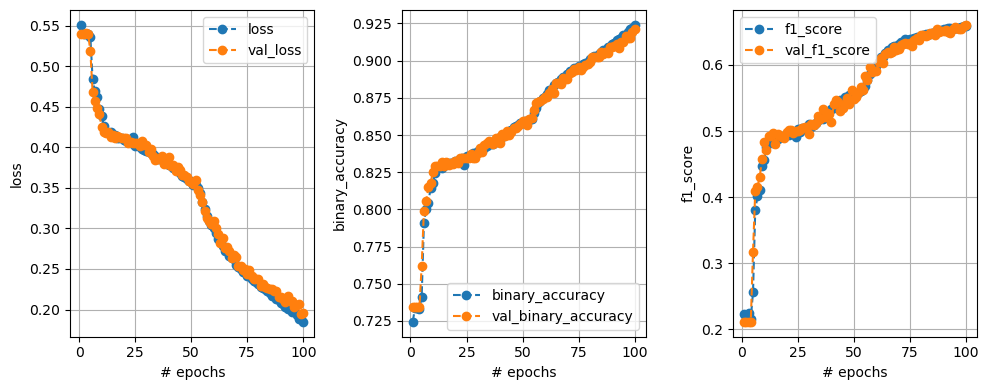

151/151 [==============================] - 4s 25ms/step - loss: 0.1848 - binary_accuracy: 0.9241 - f1_score: 0.6591 - val_loss: 0.1959 - val_binary_accuracy: 0.9213 - val_f1_score: 0.6605 - lr: 0.0010
Total training time: 381.00 seconds


In [80]:
checkpoint_twoLSTM = f"{home}/saved_results/two_LSTM.h5"

trained_twoLSTM, timer_twoLSTM = train_model(two_LSTM, X_train, y_train, X_val, y_val,
                                epochs=100, batch_size=256, patience=5,
                                showLR=False, checkpoint_filepath=checkpoint_twoLSTM,
                                reduce_learning_rate=True)

### Evaluation of accuracy and loss with the test set

In [81]:
test_loss_twoLSTM, test_acc_twoLSTM, test_f1_twoLSTM = two_LSTM.evaluate(X_test, y_test)

151/151 [==============================] - 1s 8ms/step - loss: 0.1921 - binary_accuracy: 0.9209 - f1_score: 0.6532


### Representation of time for each epoch and calculation of total training time

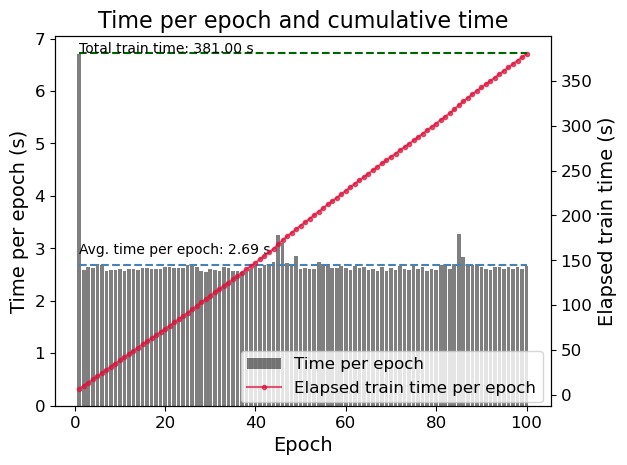

In [82]:
plot_time_per_epoch(timer_twoLSTM)

<p><strong>Comments:</strong></p>
<p>Using the <i>2-layer LSTM</i> network completes training in about 381 seconds with an average of 2.7 seconds per epoch. The number of trained parameters is 29,989, slightly higher than the parameters of the <i>2-layer GRU</i> network (22,821 parameters). It is also observed that the loss decreases from an initial value of approximately 0.6 to 0.18 and the training is completed in 100 epochs. The final loss values ​​are 0.1848 and 0.0.1959 for training and validation, respectively, worse than the <i>2-layer GRU</i> network (0.0484 and 0.0662 for training and validation). Regarding accuracy and F1-Score, the maximum training values ​​are 0.9241 and 0.6591, which represent a deterioration of 0.06 compared to the <i>GRU with two layers</i> network. For the validation set, the values ​​are 0.9213 and 0.6605, with a deterioration similar to that of the training set. Finally, the evaluation of the results on the test set returns values ​​of 0.1921, 0.9209 and 0.6532 for the loss, accuracy and F1-Score, which also follow the trend mentioned above compared to the <i>GRU with two layers</i> network.</p>

<p>Thus, the results obtained imply 0.1 seconds more per epoch, that is, 10 seconds more training. However, they lead to a deterioration in the results and, therefore, the <i>GRU network with two layers</i> seems to be the best option.</p>

# 3. Choosing the best model and *fine tuning* (2 points)

In the previous section we have already tested several different types of models. Now, based on performance, complexity (number of parameters) and training time, we need to choose the type of model that best suits our problem.

## 3.1 Model comparison

In [85]:
import pandas as pd

def summarize_models(
	histories: list, callbacks: list, model_names: list, test_losses: list, 
	test_accuracies: list, test_f1_scores: list
) -> pd.DataFrame:
	"""
	Gets the results for the different models and outputs a dataframe with the
	required comparison table.
	"""
	rows = []
	for i in range(len(histories)):
		model_name = model_names[i]
		history = histories[i]
		callback = callbacks[i]
		num_params = callback.model.count_params()
		epoch_train_times = callback.epoch_train_times
		epoch_times = callback.epoch_times
		avg_epoch_time = np.mean(callback.epoch_times)
		total_time = callback.total_time
		time_per_epoch = total_time / len(history.epoch)
		test_loss = test_losses[i]
		test_acc = test_accuracies[i]
		test_f1 = test_f1_scores[i]
		row = [model_name, time_per_epoch, avg_epoch_time, num_params,
									total_time, test_loss, test_acc, test_f1]
		rows.append(row)
	df = pd.DataFrame(rows, columns=['Model name', 'Time/Epoch',
					'Avg. Epoch duration (s)', 'Model parameters', 
					'Training time (s)', 'Test loss', 
					'Test accuracy', 'Test F1 score'])
	return df

In [86]:
histories = [trained_simpleRNN, trained_simpleGRU, trained_twoGRU, trained_twoLSTM]
callbacks = [timer_simpleRNN, timer_simpleGRU, timer_twoGRU, timer_twoLSTM]
model_names = ["SimpleRNN", "GRU (one layer)", "GRU (two layers)", "LSTM (two layers)"]
test_losses = [test_loss_simpleRNN, test_loss_simpleGRU, test_loss_twoGRU, test_loss_twoLSTM]
test_accuracies = [test_acc_simpleRNN, test_acc_simpleGRU, test_acc_twoGRU, test_acc_twoLSTM]
test_f1_scores = [test_f1_simpleRNN, test_f1_simpleGRU, test_f1_twoGRU, test_f1_twoLSTM]

summary_results = summarize_models(histories, callbacks, model_names, test_losses, test_accuracies, test_f1_scores)

In [87]:
summary_results

Model name  Time/Epoch  Avg. Epoch duration (s)  Model parameters   
0          SimpleRNN    8.182838                 7.065105             17541  \
1    GRU (one layer)    2.682007                 1.576610             13573   
2   GRU (two layers)    3.723552                 2.609829             22821   
3  LSTM (two layers)    3.810037                 2.690435             29989   

   Training time (s)  Test loss  Test accuracy  Test F1 score  
0          49.097029   0.546582       0.730523       0.249664  
1         268.200665   0.153110       0.942276       0.670721  
2         372.355160   0.058032       0.983056       0.688541  
3         381.003713   0.192109       0.920930       0.653170

<p><strong>Comments:</strong></p>
<p>Taking into account the arguments presented in the previous sections and looking at the comparative table, it can be concluded that the best model in terms of performance (<i>Accuracy</i> and <i>F1-Score</i>) is the <i>GRU network with two layers</i>, since it is the model that obtains the best values. In addition, taking into account the performance of both metrics and time, the <i>SimpleRNN</i> network can be discarded since it is the model that would take the longest to train and the one that obtains the worst metrics. Regarding the LSTM model, it can also be discarded since it does not imply any improvement for the case study despite using a cell type similar to the GRU and more complex; the GRU network combines the state with the network response and also performs a weighting of the previous and current states. (Chapter 2 of [1])</p>
<p>However, the decision between <i>GRU networks with one or two layers</i> will depend on the type of application and the requirements. In this case, it has been obtained to prioritize the improvement in the error detection capacity, since the training of a model in production is not usually a common occurrence, it usually takes place weekly or over a longer period, unless the changes in the patterns in the data are very common and the degradation of the model is rapid. Therefore, this increase in the time of the <i>GRU network with two layers</i> would have little impact, while the ability to detect errors would be very important.</p>

<p><strong>References:</strong></p>
<ul>
<li> [1] Toni Lozano Bagén, *Redes Neuronales Recurrentes*, UOC (2023).
</ul>

## 3.2 *Fine Tuning* of parameters for the chosen model

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

### Model definition

In [102]:
def model_tuning(hp: kt.Hyperband) -> Model:
	"""
	Sets up a model for tuning with keras_tuner.

	The code is based on the implementations found in:
	- https://keras.io/keras_tuner/
	- https://keras.io/api/keras_tuner/tuners/hyperband/
	"""
	# Set the units for the first layer
	units = hp.Int('units', min_value=16, max_value=64, step=16)

	# Set up the model with the input, GRU and Dense layers
	input_layer = Input(shape=(90, 3))
	gru_layer1 = GRU(units=units, activation='tanh', return_sequences=True)(input_layer)
	gru_layer2 = GRU(units=units//2, dropout=hp.Choice('dropout', [0.0, 0.1, 0.25, 0.7]), activation='tanh')(gru_layer1)
	output_layer = Dense(5, activation='sigmoid')(gru_layer2)
	model = Model(inputs=input_layer, outputs=output_layer)

	# Compile the model using Adam as the optimizer and the binary crossentropy loss
	model.compile(optimizer=Adam(
					learning_rate=hp.Choice('lr', [1e-2, 5e-3, 1e-3])), 
					loss='binary_crossentropy',
					metrics=[
						'binary_accuracy',
						F1Score(num_classes=5, average='weighted')
					])
	return model

### Search for the best parameters

In [105]:
timer_cb = TimerCallback()
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
	filepath=f'{home}/saved_results/tuning.h5', save_weights_only=True, monitor='val_loss',
	mode='min', save_best_only=True
)

tuner = kt.Hyperband(model_tuning, objective='val_binary_accuracy', max_epochs=100)
tuner.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[timer_cb, early_stop, reduce_lr, checkpoint])


Trial 46 Complete [00h 00m 32s]
val_binary_accuracy: 0.9520348906517029

Best val_binary_accuracy So Far: 0.9643272161483765
Total elapsed time: 00h 25m 43s
INFO:tensorflow:Oracle triggered exit


The best model is saved in an object for reuse.

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

The model is saved to a file.

In [168]:
from tensorflow.keras.models import save_model
save_model(best_model, f'{home}/saved_results/best_model_tuner.h5')

In [ ]:
# tuner.results_summary()

In [152]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print("The best learning rate is:", best_params.get('lr'))
print("The best dropout is:", best_params.get('dropout'))
print("The best number of units is:", best_params.get('units'))

La millor learning rate és: 0.01
El millor dropout és: 0.0
El millor nombre d'unitats és: 64


Next, the code is placed to load the model in case it is necessary

In [16]:
best_model_loaded = load_model(f'{home}/saved_results/best_model_tuner.h5')

## 3.3 Training the model with custom hyperparameters

### Model definition

In [17]:
two_GRU_best_params = twoGRU_model(input_shape=(90, 3), num_classes=5, units=64, lr=0.01)
two_GRU_best_params.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 90, 3)]           0         
                                                                 
 gru_3 (GRU)                 (None, 90, 64)            13248     
                                                                 
 gru_4 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


### Model training

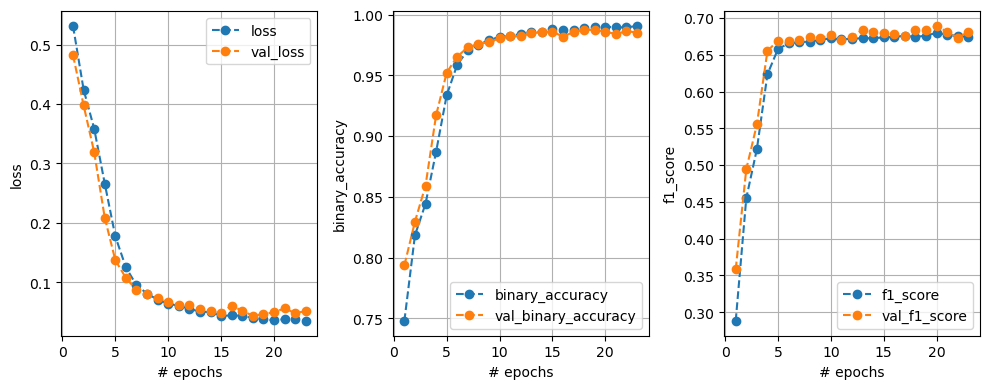

151/151 [==============================] - 4s 24ms/step - loss: 0.0349 - binary_accuracy: 0.9907 - f1_score: 0.6745 - val_loss: 0.0516 - val_binary_accuracy: 0.9853 - val_f1_score: 0.6809
Total training time: 95.93 seconds


In [161]:
checkpoint_twoGRU_best_params= f"{home}/saved_results/twoGRU_best_params.h5"

trained_twoGRU_best_params, timer_twoGRU_best_params = \
						train_model(two_GRU_best_params, X_train, y_train, X_val, y_val,
                        epochs=100, batch_size=256, patience=5,
                        showLR=False, checkpoint_filepath=checkpoint_twoGRU_best_params,
                        reduce_learning_rate=False)

### Evaluation of accuracy and loss with the test set

In [164]:
test_loss_twoGRU_best_params, test_acc_twoGRU_best_params, test_f1_twoGRU_best_params = two_GRU_best_params.evaluate(X_test, y_test)

151/151 [==============================] - 1s 8ms/step - loss: 0.0485 - binary_accuracy: 0.9872 - f1_score: 0.6720


### Representation of time for each epoch and calculation of total training time

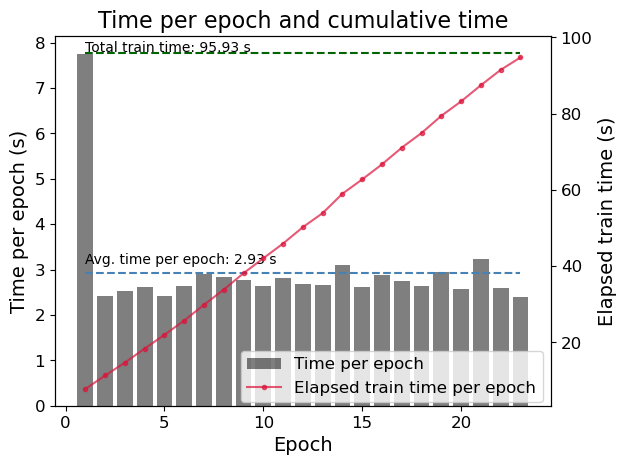

In [165]:
plot_time_per_epoch(timer_twoGRU_best_params)

### Predictions with the model
Next, predictions will be made with the best model to analyze the results.

In [261]:
two_GRU_best_params.load_weights(f'{home}/saved_results/twoGRU_best_params.h5')

In [ ]:
y_pred_twoGRU_best_params = two_GRU_best_params.predict(X_test)

In [263]:
y_pred_twoGRU_best_params

array([[3.2334679e-03, 1.1089372e-02, 5.1888688e-03, 1.7764703e-04,
        9.9998689e-01],
       [4.7725220e-03, 4.6387382e-02, 8.3857328e-03, 9.9952126e-01,
        6.8588345e-04],
       [1.2410566e-03, 5.1338938e-03, 5.5763889e-03, 1.3463295e-04,
        9.9998915e-01],
       ...,
       [9.9926740e-01, 2.5647627e-03, 1.6178741e-03, 2.1112408e-04,
        1.5537803e-04],
       [6.9769910e-03, 8.0627035e-03, 1.2687813e-03, 2.5536845e-04,
        1.7531500e-03],
       [1.1281477e-03, 9.9902916e-01, 1.3990457e-01, 1.7851982e-02,
        9.9999380e-01]], dtype=float32)

In [264]:
y_pred_twoGRU_best_params[20]

array([9.9829727e-01, 3.4044092e-03, 1.4821341e-02, 2.0777667e-03,
       1.5562566e-04], dtype=float32)

In [267]:
y_pred_twoGRU_best_params.shape

(4815, 5)

Predictions are converted to binary format.

In [266]:
y_pred_binary_twoGRU_best_params = np.where(y_pred_twoGRU_best_params > 0.5, 1, 0)
y_pred_binary_twoGRU_best_params

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1]])

In [268]:
y_test[20]

array([1, 0, 0, 0, 0])

In [269]:
y_pred_binary_twoGRU_best_params[20]

array([1, 0, 0, 0, 0])

<p><strong>Comments:</strong></p>
<p>Using the <i>GRU network with two layers</i> with the optimized parameters finishes the training in about 96 seconds, that is, 4 times less than the model trained in section 2 (381 seconds) with an average of 2.9 seconds per epoch, slightly higher than the initial model (2.6 seconds). The results obtained indicate how the loss, accuracy and F1-Score of training, validation and testing are slightly better with values ​​of:
<ul>
<li>0.0349, 0.0516, 0.0485 for the loss (training, validation and testing)</li>
<li>0.9907, 0.9853, 0.9872 for the accuracy (training, validation and testing)</li>
<li>0.6745, 0.6809, 0.6720 for the F1-Score (training, validation and testing)</li>
</ul>
</p>

<p>Which represents an improvement of approximately 0.01 compared to the values ​​of the network trained in section 2.</p>

<p>Finally, it can be seen how the predictions made with the best model return a vector of dimensions (4815, 5), the same dimensions as the <i>y_test</i> dataset. If these predictions are transformed to binary format and the result is checked for a specific array, it can be seen that the resulting label vector matches the original, confirming that the model is capable of making very accurate predictions.</p>

# 4. Location of errors (2 points)

## 4.1 Defining a new model for error localization

To find when an error occurs in the reading of a sensor, a given sequence will be divided into segments and the classification will be performed on each segment individually. To do this, it is necessary to define a new model that divides the input signal and these parts will be passed to the next _layer_ where the classifier that we have already trained previously will be used.

### Model definition

In [18]:
def error_detection_model(
	num_classes: int, n_sensors: int, lr: int, n_length: int, best_model: Model
) -> Model:
	"""
	Creates the model with the previous requirements.
	"""
	# Create the input layer and split it into subsquences of length n_length
	input_layer = Input(shape=(None, n_sensors))
	reshaped_layer = Reshape(target_shape=(-1, n_length, n_sensors))(input_layer)

	# Classify each subsequence with the best_model and obtain the maximum value
	clf_layer = TimeDistributed(best_model)(reshaped_layer)
	final_layer = GlobalMaxPool1D()(clf_layer)

	# Define and compile the model
	subseq_model = Model(inputs=input_layer, outputs=final_layer)
	subseq_model.compile(optimizer=Adam(learning_rate=lr),
						loss='binary_crossentropy',
						metrics=[
							'binary_accuracy',
							F1Score(num_classes=num_classes, average='weighted')
						])

	return subseq_model

In [19]:
best_model = twoGRU_model(input_shape=(None, 3), num_classes=5, units=64, lr=0.01)
best_model.load_weights(f'{home}/saved_results/twoGRU_best_params.h5')

subseq_model = error_detection_model(num_classes=5, n_sensors=3, lr=0.01, 
								n_length=10, best_model=best_model)
subseq_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, 3)]         0         
                                                                 
 reshape (Reshape)           (None, None, 10, 3)       0         
                                                                 
 time_distributed (TimeDistr  (None, None, 5)          22821     
 ibuted)                                                         
                                                                 
 global_max_pooling1d (Globa  (None, 5)                0         
 lMaxPooling1D)                                                  
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


### Model training

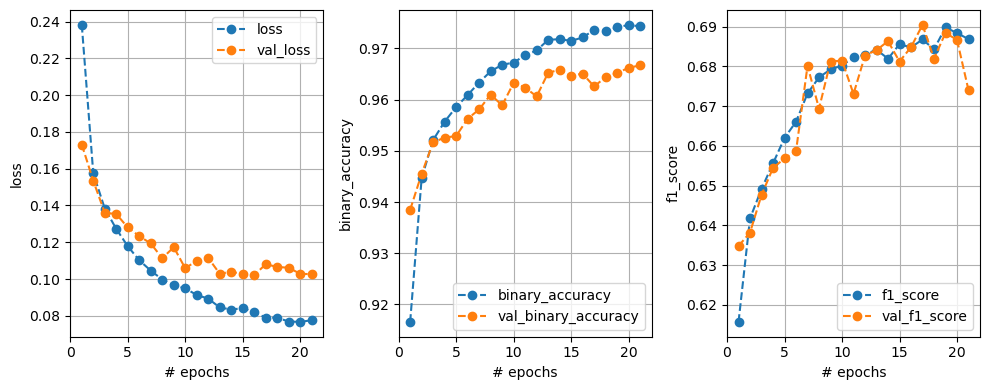

151/151 [==============================] - 3s 19ms/step - loss: 0.0776 - binary_accuracy: 0.9743 - f1_score: 0.6868 - val_loss: 0.1027 - val_binary_accuracy: 0.9667 - val_f1_score: 0.6740
Total training time: 70.33 seconds


In [75]:
checkpoint_twoGRU_sequences= f"{home}/saved_results/twoGRU_sequences.h5"

trained_twoGRU_sequences, timer_twoGRU_sequences = \
						train_model(subseq_model, X_train, y_train, X_val, y_val,
                        epochs=100, batch_size=256, patience=5,
                        showLR=False, checkpoint_filepath=checkpoint_twoGRU_sequences,
                        reduce_learning_rate=False)

### Evaluation of accuracy and loss with the test set

In [81]:
test_loss_twoGRU_sequences, test_acc_twoGRU_sequences, test_f1_twoGRU_sequences = subseq_model.evaluate(X_test, y_test)

151/151 [==============================] - 1s 4ms/step - loss: 0.0952 - binary_accuracy: 0.9678 - f1_score: 0.6864


### Representation of time for each epoch and calculation of total training time

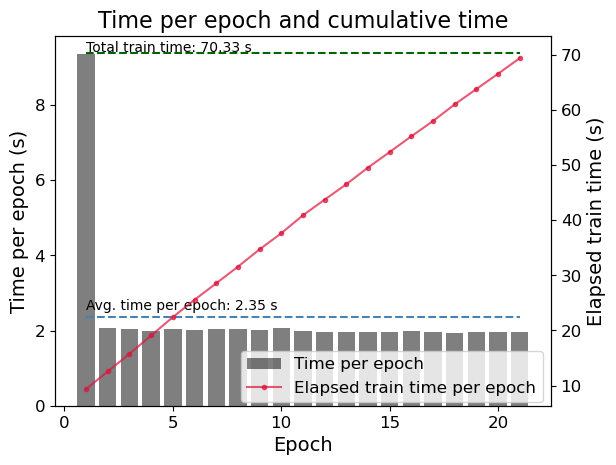

In [82]:
plot_time_per_epoch(timer_twoGRU_sequences)

### Predictions with the model
Next, predictions will be made with the model to compare the results with those of the best model from exercise 3.2.

In [254]:
subseq_model.load_weights(f'{home}/saved_results/twoGRU_sequences.h5')

In [270]:
y_pred_subseq = subseq_model.predict(X_test)

151/151 [==============================] - 0s 3ms/step


In [271]:
y_pred_subseq

array([[1.1896427e-02, 2.0808978e-02, 8.0624260e-03, 1.9116374e-03,
        9.9986863e-01],
       [2.0229616e-03, 1.4911406e-02, 8.5847834e-03, 9.9965549e-01,
        1.8816987e-03],
       [6.9568842e-03, 4.1227778e-03, 5.3733755e-03, 6.9531193e-04,
        9.9999356e-01],
       ...,
       [9.9954331e-01, 5.6170207e-03, 5.5670100e-03, 7.7605923e-04,
        3.0833573e-04],
       [6.7770560e-03, 4.5709866e-03, 5.3594611e-03, 2.4791865e-03,
        1.8806351e-05],
       [4.6464177e-03, 9.9989879e-01, 5.1195282e-03, 3.8144742e-03,
        9.9985898e-01]], dtype=float32)

In [273]:
y_pred_subseq[20]

array([9.99942064e-01, 1.79432742e-02, 1.06219845e-02, 3.34776414e-04,
       1.31597462e-05], dtype=float32)

In [276]:
y_pred_subseq.shape

(4815, 5)

The predictions are then transformed into binary format (0 or 1).

In [274]:
y_pred_binary_subseq = np.where(y_pred_subseq > 0.5, 1, 0)

In [275]:
y_pred_binary_subseq[20]

array([1, 0, 0, 0, 0])

In [277]:
y_test[20]

array([1, 0, 0, 0, 0])

## Try a smaller location

### Model definition

In [22]:
model_len_1 = twoGRU_model(input_shape=(None, 3), num_classes=5, units=64, lr=0.01)
model_len_1.load_weights(f'{home}/saved_results/twoGRU_best_params.h5')

len_1_model = error_detection_model(num_classes=5, n_sensors=3, lr=0.01,
										n_length=1, best_model=model_len_1)

### Model training

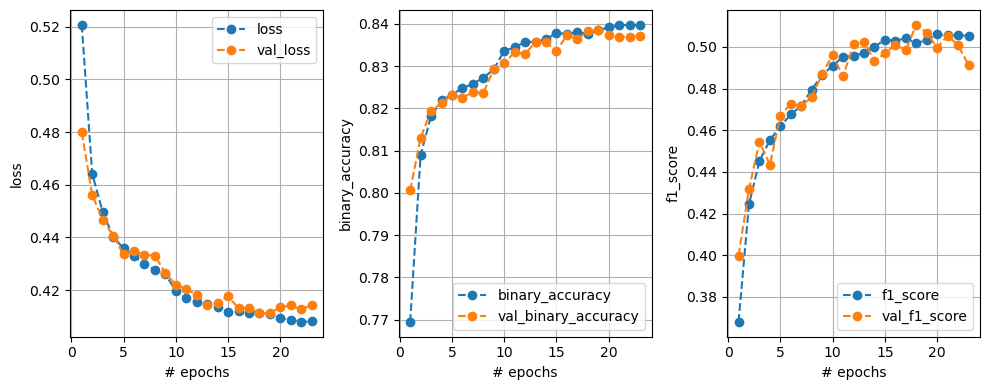

151/151 [==============================] - 3s 18ms/step - loss: 0.4081 - binary_accuracy: 0.8397 - f1_score: 0.5053 - val_loss: 0.4143 - val_binary_accuracy: 0.8372 - val_f1_score: 0.4914
Total training time: 68.62 seconds


In [80]:
checkpoint_twoGRU_len1= f"{home}/saved_results/twoGRU_len1.h5"

trained_twoGRU_len1, timer_twoGRU_len1 = \
						train_model(len_1_model, X_train, y_train, X_val, y_val,
                        epochs=100, batch_size=256, patience=5,
                        showLR=False, checkpoint_filepath=checkpoint_twoGRU_len1,
                        reduce_learning_rate=False)

### Evaluation of accuracy and loss with the test set

In [83]:
test_loss_twoGRU_len1, test_acc_twoGRU_len1, test_f1_twoGRU_len1 = len_1_model.evaluate(X_test, y_test)

151/151 [==============================] - 1s 4ms/step - loss: 0.4127 - binary_accuracy: 0.8387 - f1_score: 0.4952


### Representation of time for each epoch and calculation of total training time

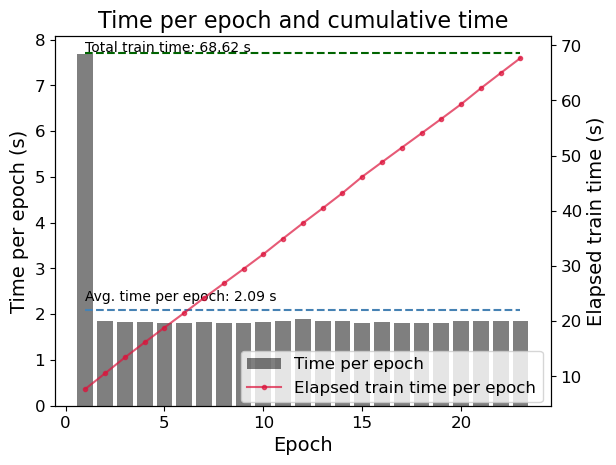

In [84]:
plot_time_per_epoch(timer_twoGRU_len1)

<p><strong>Also, comment on the effects of reshaping to have N=10 sub-sequences on localization. If we had chosen N=1, 2 or 5, what would change? </strong></p>

<p>It can be seen that the model where the sequences have been cut at values ​​of 10 has 22,821 parameters like those of the <i>GRU network with two layers</i>. In addition, the training is completed in 70 seconds, about 30 seconds faster than the best model. Also the average time per epoch is 2 seconds.</p>
<p>If we analyze the performance of the model, we can see how the loss and accuracy values ​​are slightly worse than in the case of the best model, while the F1-Score is relatively similar:</p>
<p><strong>Metrics for model with subsequences of length 10:</strong></p>
<ul>
<li>0.0776, 0.1027, 0.0961 for the loss (training, validation and testing)</li>
<li>0.9743, 0.9667, 0.9679 for the accuracy (training, validation and testing)</li>
<li>0.6868, 0.6740, 0.6874 for the F1-Score (training, validation and testing)</li>
</ul>

<p><strong>Metrics better model:</strong></p>
<ul>
<li>0.0349, 0.0516, 0.0485 for the loss (training, validation and test)</li>
<li>0.9907, 0.9853, 0.9872 for the accuracy (training, validation and test)</li>
<li>0.6745, 0.6809, 0.6720 for the F1-Score (training, validation and test)</li>
</ul>

<p>Also, you can see how when making predictions with the data, an array of dimensions (4815, 5) is obtained, that is, the dimensions of <i>y_test</i> and the same as those of the model in exercise 3.2 with the best parameters. If we analyze the results obtained from the predictions for a specific array, we can see how the values ​​of the <code>subseq_model</code> model probabilities are very similar to those obtained with <code>two_GRU_best_params</code>, [9.99942064e-01, 1.79432742e-02, 1.06219845e-02, 3.34776414e-04, 1.31597462e-05] and [9.9829727e-01, 3.4044092e-03, 1.4821341e-02, 2.0777667e-03, 1.5562566e-04], respectively. Thus, when calculating the values ​​in binary format, we obtain exactly the same result, that is, vectors [1, 0, 0, 0, 0] for both cases.</p>

<p>In view of the results, it seems that it makes no sense to train with the same data. The main reason is that we are dividing the original sequences into subsequences, but not all of them contain errors. Therefore, the original labels will not be adequate to label the set with subsequences and, probably, it would be necessary to use a different set where each of the subsequences would be labeled. On the other hand, we end up calculating the maximum value of the predictions for each subsequence, therefore, we will be performing the same procedure as for the best trained model with the only difference that we are dividing the data into smaller sequences, as can be seen in the prediction results.</p>

<p>Another important aspect is that cutting the data can reduce the accuracy of the model when detecting errors, as can be seen in the results of training with sequence 1. This model takes the same time to train, but the metrics are worse:</p>
<p><strong>Metrics for model with subsequences of length 1:</strong></p>
<ul>
<li>0.4081, 0.4143, 0.4127 for the loss (training, validation and testing)</li>
<li>0.8397, 0.8372, 0.8387 for the accuracy (training, validation and testing)</li>
<li>0.5053, 0.4914, 0.4952 for the F1-Score (training, validation and testing)</li>
</ul>

<p>A possible reason is that the training window is not large enough and, therefore, the model does not know how to identify exactly what type of sequence contains the error, which is why the result gets worse as the subsequences get smaller.</p>

## 4.2 Fault location model

In [21]:
best_model = twoGRU_model(input_shape=(None, 3), num_classes=5, units=64, lr=0.01)
best_model.load_weights(f'{home}/saved_results/twoGRU_best_params.h5')

model_loc = error_detection_model(num_classes=5, n_sensors=3, lr=0.01, 
								n_length=10, best_model=best_model)
model_loc.load_weights(f'{home}/saved_results/twoGRU_sequences.h5')

In [23]:
loc_model = Model(model_loc.inputs, model_loc.layers[-2].output)
loc_model.compile(optimizer=Adam(learning_rate=0.01),
				loss='binary_crossentropy',
				metrics=[
					'binary_accuracy',
					F1Score(num_classes=5, average='weighted')
				])
loc_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, 3)]         0         
                                                                 
 reshape_1 (Reshape)         (None, None, 10, 3)       0         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 5)          22821     
 tributed)                                                       
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


### We make predictions with the model

In [33]:
predictions = loc_model.predict(X_test)
# Apply threshold of 0.5 to the output probabilities to transform the predictions to 0 and 1
binary_predictions = (predictions >= 0.5).astype(int)

151/151 [==============================] - 3s 3ms/step


Below, the results are presented for a random index and for the different arrays *y_test*, *predictions* and *binary_predictions*.

In [251]:
y_test[20]

array([1, 0, 0, 0, 0])

In [26]:
predictions[20]

array([[2.95700994e-03, 2.53948942e-03, 3.41043761e-03, 2.84985435e-04,
        8.16323154e-06],
       [1.95858791e-03, 1.09738891e-03, 2.99008284e-03, 3.34776414e-04,
        1.92772109e-06],
       [7.32796616e-04, 1.79432742e-02, 1.06219845e-02, 2.00396214e-04,
        1.31597462e-05],
       [1.23600569e-03, 1.99631765e-03, 4.27363813e-03, 2.03120537e-04,
        9.26907524e-06],
       [1.43208168e-03, 9.28797119e-04, 3.48663842e-03, 1.61765449e-04,
        7.62571017e-06],
       [2.18716171e-03, 1.53215369e-03, 3.92842805e-03, 8.49102507e-05,
        1.97440681e-06],
       [9.99942064e-01, 8.59026797e-03, 7.90394144e-04, 9.31812829e-05,
        7.59173645e-06],
       [1.56791951e-03, 1.56920450e-03, 3.41399875e-03, 1.69561041e-04,
        3.29631030e-06],
       [1.81231799e-03, 1.60300988e-03, 3.36793438e-03, 1.87004771e-04,
        5.42219823e-06]], dtype=float32)

In [281]:
binary_predictions[20]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

The dimensions of the arrays are also checked.

In [280]:
y_test.shape

(4815, 5)

In [278]:
predictions.shape

(4815, 9, 5)

<p><strong>Comments:</strong></p>
<p>It can be seen how the elimination of the <code>GlobalMaxPool1D</code> layer no longer obtains prediction values ​​for a complete sequence, that is, where previously a single array was obtained, now 9 are obtained. Furthermore, if we analyze a specific case as in section 4.1, we can see how previously the maximum probability value was obtained for each class ([9.99942064e-01, 1.79432742e-02, 1.06219845e-02, 3.34776414e-04, 1.31597462e-05]), while now this is no longer the case and 9 arrays are obtained with probabilities of appearance of each class for each one. This is especially suitable for identifying the subsequence where the error is located. Thus, as can be seen from the example presented and transformed into a binary array, the error is located in subsequence 7, while in exercise 4.1 only a single array indicating the error was obtained, but not the sequence where it occurred. Therefore, eliminating the <code>GlobalMaxPool1D</code> layer effectively allows the identification that was intended.</p>

## 5. Error display (1 point)

In [225]:
def plot_error_subsequence(
	X: np.ndarray, y: np.ndarray, model: Model, n_subsequences: int = 9,
	length: int = 10, n_sensors: int = 3, max_fontsize: int = 20, 
	figure_size: tuple[int, int] = (10, 3), detection_threshold: float = 0.5
) -> None:
	"""
	Plots a reading from sensor data contained in the X array.
	The title of the figure indicates the original error and the error in each
	subsequence.
	"""
	def reshape_X_and_create_indices(
		X: np.ndarray, n_subsequences: int, length: int, n_sensors: int
	) -> tuple[np.ndarray, np.ndarray]:
		"""
		Reshape the X array to have the right format for the model and creates
		a list of indices for each subsequence.
		"""
		# Reshape the input array to have the right shape
		X_reshaped = X.reshape(-1, length, n_sensors)
		# Create the indices of X and split it into the elements of y_preds_reshaped
		X_indices = np.arange(0, X.shape[0], 1)
		X_indices_split = np.array_split(X_indices, n_subsequences)
		return X_reshaped, X_indices_split

	def get_ypreds_binary_split(
		X_reshaped: np.ndarray, model: Model, detection_threshold: float
	) -> tuple[np.ndarray, np.ndarray]:
		"""
		Get the predictions from the model and transform them to binary values.
		"""
		# Get the predictions and reshape the array
		y_preds = model.predict(X_reshaped)
		y_preds_reshaped = y_preds.reshape(-1, 5)
		# Transform the initial probabilities to binary values and reshape them
		y_preds_binary = (y_preds >= detection_threshold).astype(int)
		y_preds_binary_reshaped = y_preds_binary.reshape(-1, 5)
		return y_preds_reshaped, y_preds_binary_reshaped

	def build_error_string(y: np.ndarray):
		"""
		Builds the string that identifies the original errors for the title.
		"""
		error_classes = [i+1 for i in range(len(y)) if y[i]]
		# Create the title
		if len(error_classes) == 0:
			title = f"Real error (No errors): {y}"
		elif len(error_classes) == 1:
			error_class = error_classes[0]
			title = f"Real error ({error_class}): {y}"
		else:
			error_class_str = ", ".join(str(x) for x in error_classes)
			title = f"Real errors ({error_class_str}): {y}"
		return title

	def build_subsequence_string(
		y_preds_binary: np.ndarray, n_subsequences: int
	) -> tuple[list[str], list[str]]:
		"""
		Builds the string to be used in the title of the plot.
		"""
		# Build a string with the subsenquence index and the array in y_preds_binary
		str_line = []
		for i in range(n_subsequences):
			str_line.append(f"Seq. {i+1}: {y_preds_binary[i].flatten()}")
		return str_line

	X_reshaped, X_indices_split = reshape_X_and_create_indices(X, n_subsequences, length, n_sensors)
	y_preds_reshaped, y_preds_binary_reshaped = get_ypreds_binary_split(X_reshaped, model, detection_threshold)
	real_error_str = build_error_string(y)
	seq_error_str = build_subsequence_string(y_preds_binary_reshaped, n_subsequences)

	# Set up the plot
	colors_list = {1: 'crimson', 2: 'tab:purple', 3: 'gray', 4: 'tab:cyan', 5: 'tab:olive'}
	_, ax = plt.subplots(figsize=figure_size)

	# Plot the sensor data
	ax.plot(X[:, 0], color='steelblue', lw=2, label='Sensor 1')
	ax.plot(X[:, 1], color='darkorange', lw=2, label='Sensor 2')
	ax.plot(X[:, 2], color='darkorchid', lw=2, label='Sensor 3')

	# Loop over each subsequence
	for i in range(n_subsequences):
		for error_idx, error in enumerate(y_preds_reshaped[i]):
			if y_preds_binary_reshaped[i][error_idx] == 1:
				# Get the first and last indices of the corresponding X_indices_split
				first_idx = X_indices_split[i][0]
				last_idx = X_indices_split[i][-1]
				ax.axvspan(first_idx+error_idx-2, last_idx+error_idx, ymin=0, ymax=1, alpha=error, color=colors_list[error_idx+1], label=f'Error {error_idx+1}')

	# Create the legend to show only unique label/handle pairs
	handles, labels = ax.get_legend_handles_labels()
	for i in range(len(handles)):
		handles[i].set_alpha(0.8)
	by_label = dict(zip(labels, handles))
	ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=max_fontsize-4, bbox_to_anchor=(1.25, 1.0))

	# Add labels and titles
	ax.set_xlabel("Temporal axis", fontsize=max_fontsize-2)
	ax.set_ylabel("Sensor data", fontsize=max_fontsize-2)
	ax.tick_params(labelsize=max_fontsize-4)
	plt.suptitle(f"{real_error_str}", fontsize=max_fontsize, x=0.5, y=1.25)
	title_text = f"Sequence errors: \n{seq_error_str[:len(seq_error_str)//2]}\n{seq_error_str[len(seq_error_str)//2:]}"
	ax.set_title(title_text, fontsize=max_fontsize-4)
	plt.show()

In [226]:
def plot_n_error_subsequence(
	X: np.ndarray, y: np.ndarray, model: Model, n_subsequences: int = 9,
	length: int = 10, n_sensors: int = 3, max_fontsize: int = 20, 
	figure_size: tuple[int, int] = (10, 3), n_readings = 10, 
	detection_threshold: float = 0.5
) -> None:
	"""
	Randomly selects a number of readings and calls the function
	plot_error_subsequence for each of them.
	"""
	# Randomly select the indices to plot
	random_idxs = np.random.choice(len(X), n_readings, replace=False)
	for idx in random_idxs:
		plot_error_subsequence(X[idx], y[idx], model, n_subsequences, length,
										n_sensors, max_fontsize, figure_size,
										detection_threshold)

### Test with detection limit of 0.2

1/1 [==============================] - 0s 22ms/step


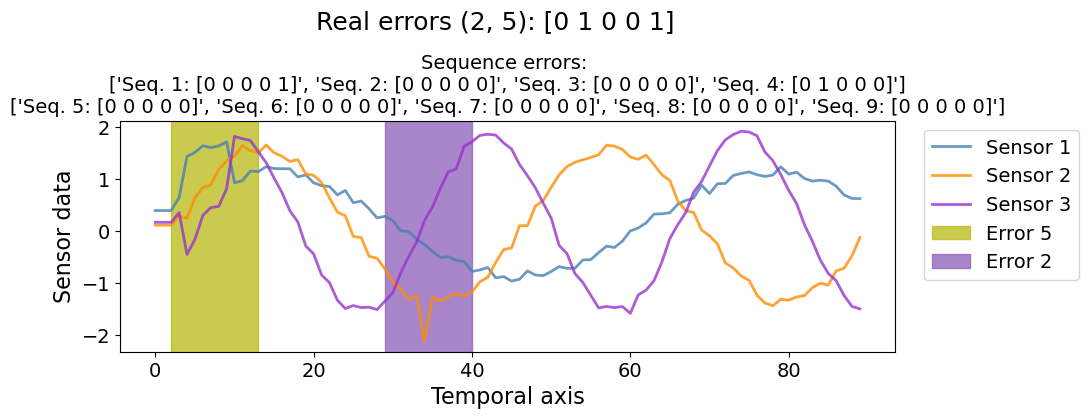

1/1 [==============================] - 0s 22ms/step


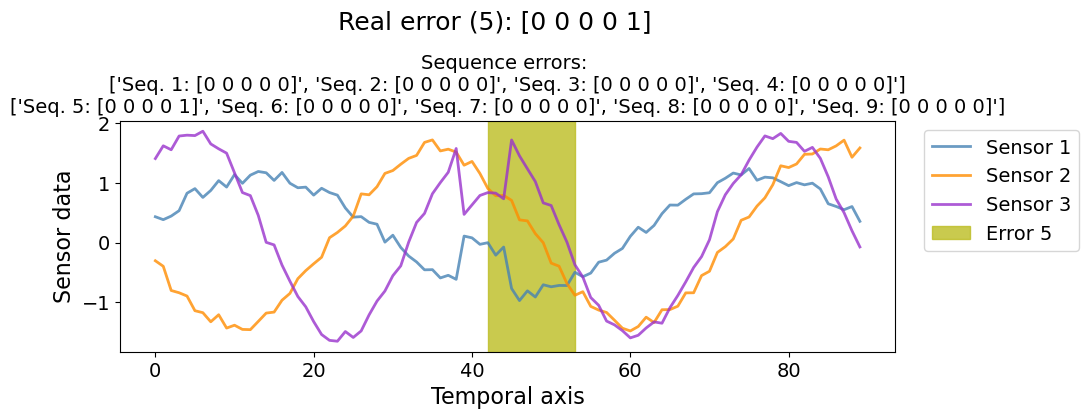

1/1 [==============================] - 0s 23ms/step


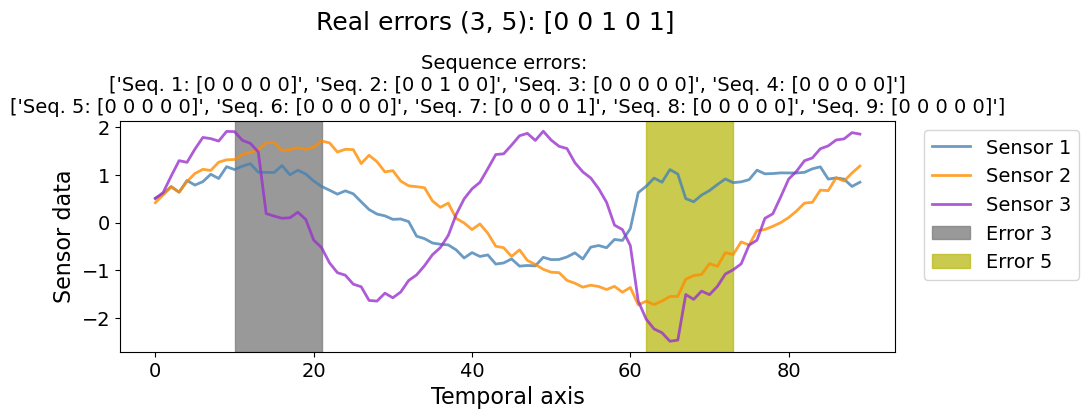

1/1 [==============================] - 0s 26ms/step


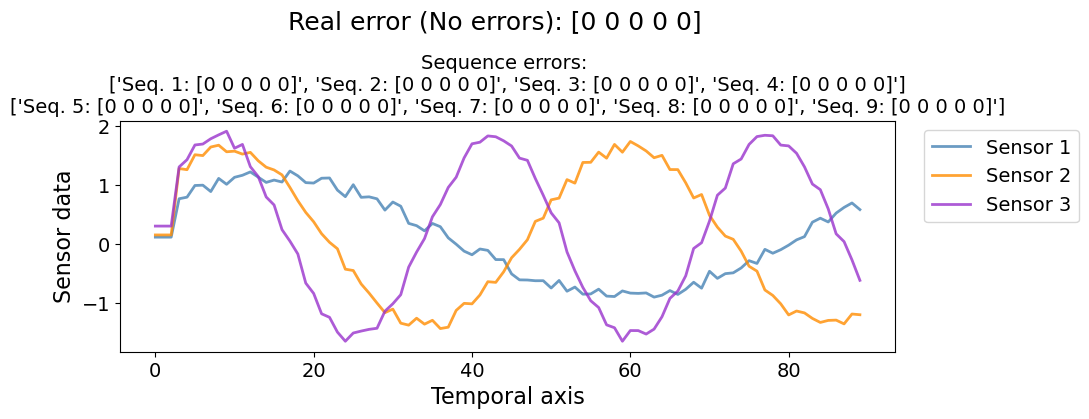

1/1 [==============================] - 0s 22ms/step


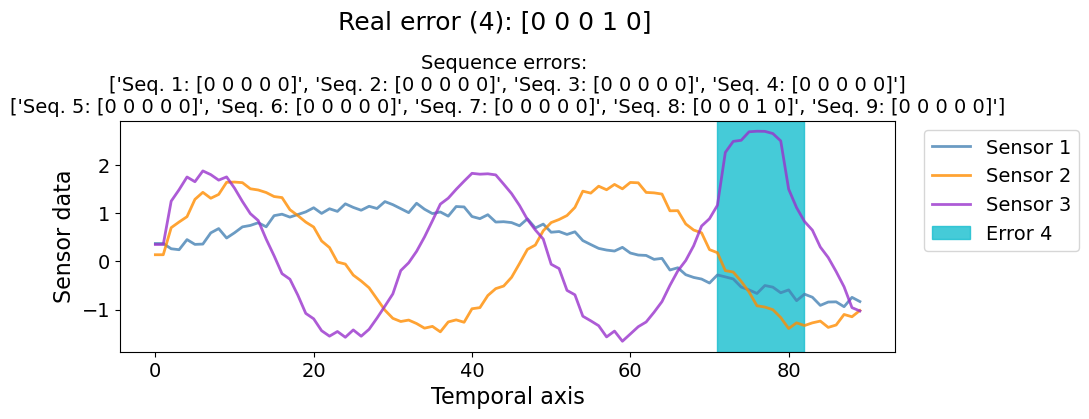

1/1 [==============================] - 0s 22ms/step


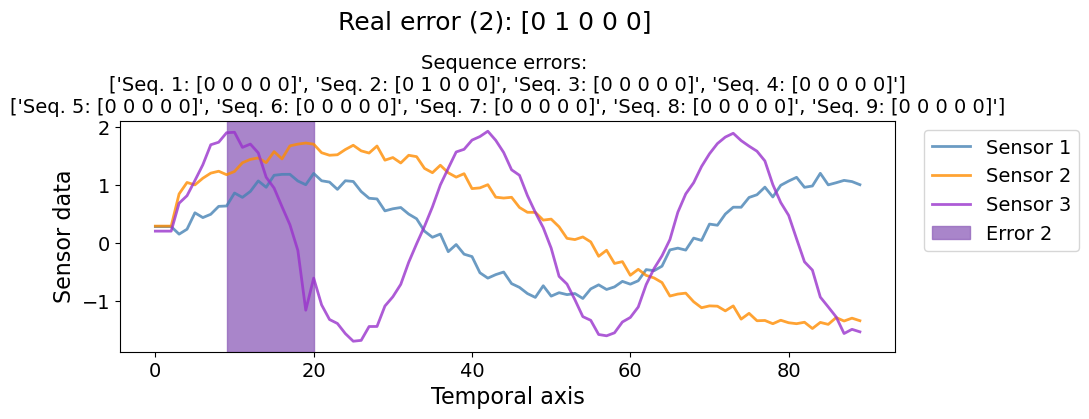

1/1 [==============================] - 0s 23ms/step


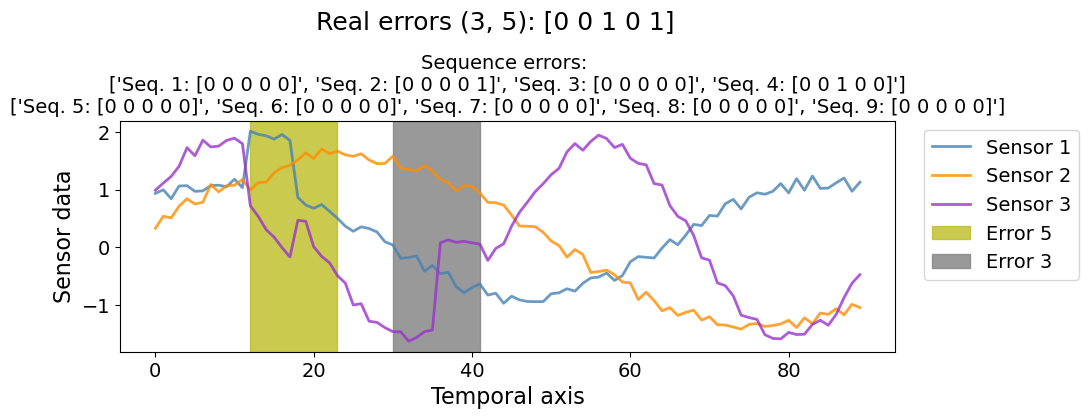

1/1 [==============================] - 0s 22ms/step


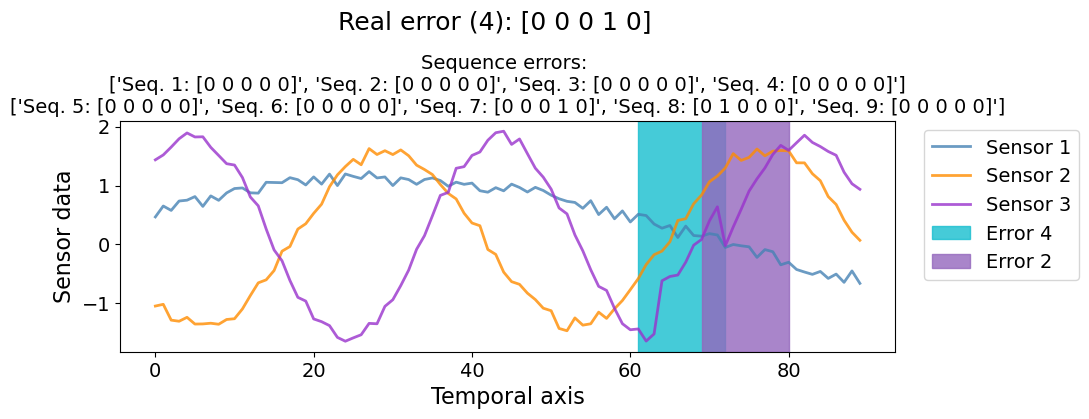

1/1 [==============================] - 0s 24ms/step


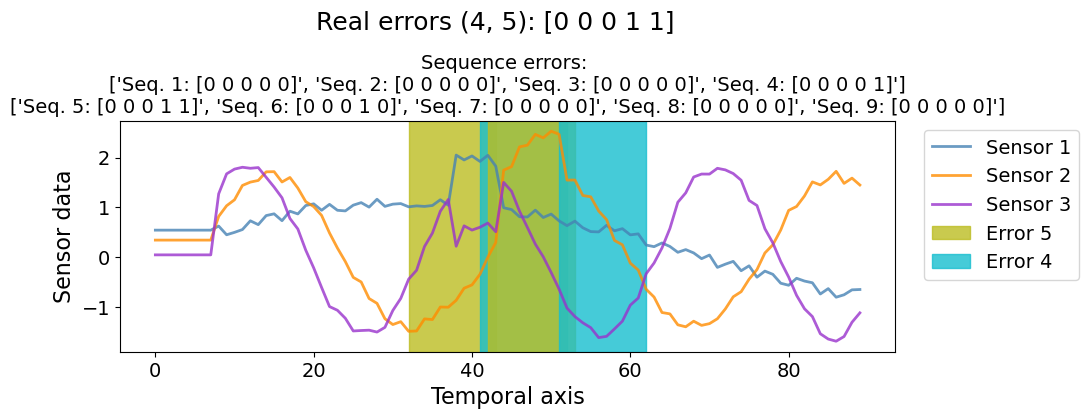

1/1 [==============================] - 0s 23ms/step


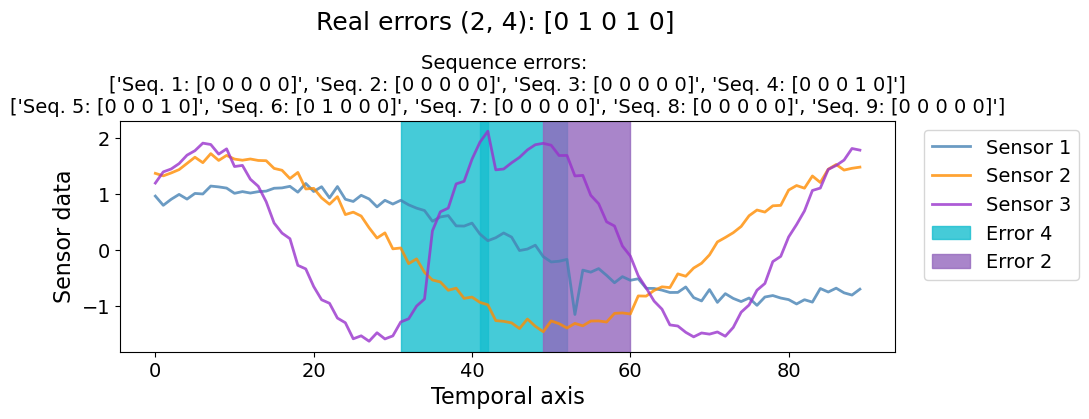

In [220]:
plot_n_error_subsequence(X=X_test, y=y_test, model=loc_model, n_subsequences=9,
									length=10, n_sensors=3, max_fontsize=18,
									figure_size=(10, 3), n_readings=10,
									detection_threshold=0.2)

### Test with detection limit of 0.5

1/1 [==============================] - 0s 34ms/step


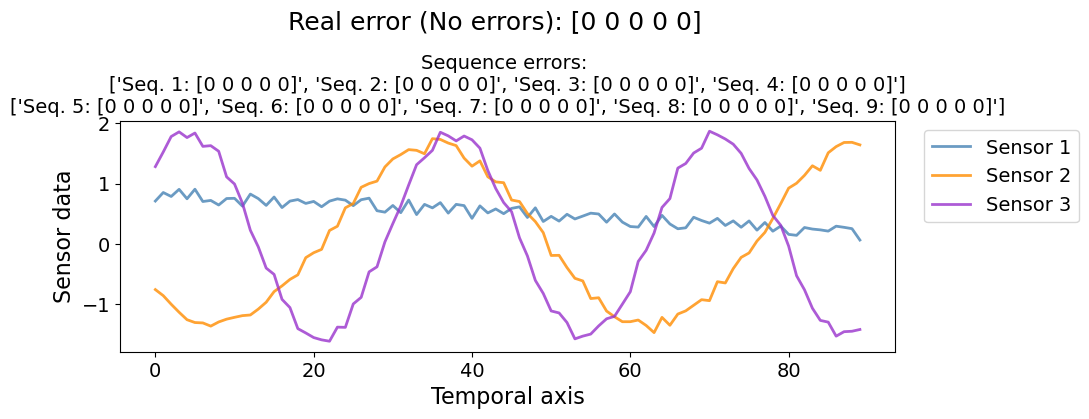

1/1 [==============================] - 0s 30ms/step


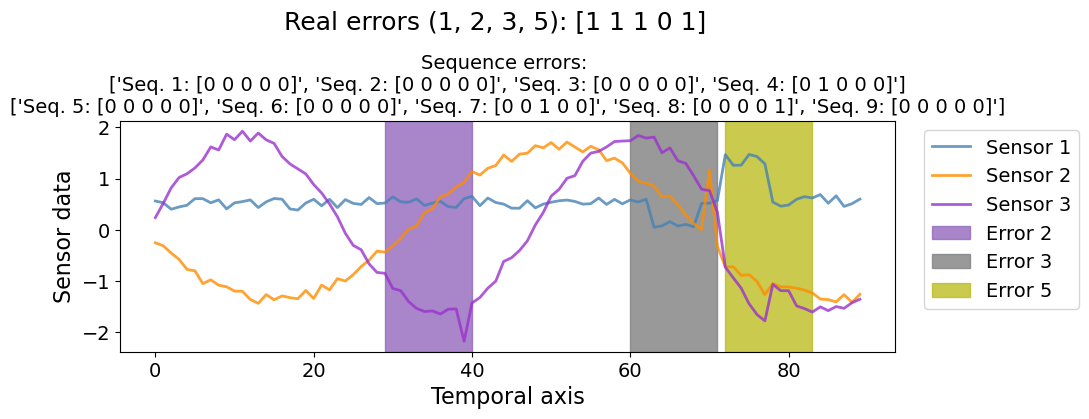

1/1 [==============================] - 0s 25ms/step


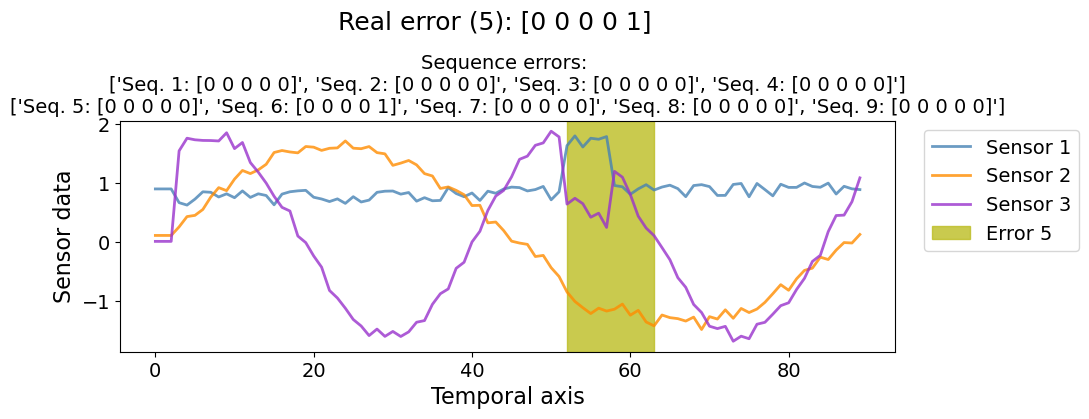

1/1 [==============================] - 0s 24ms/step


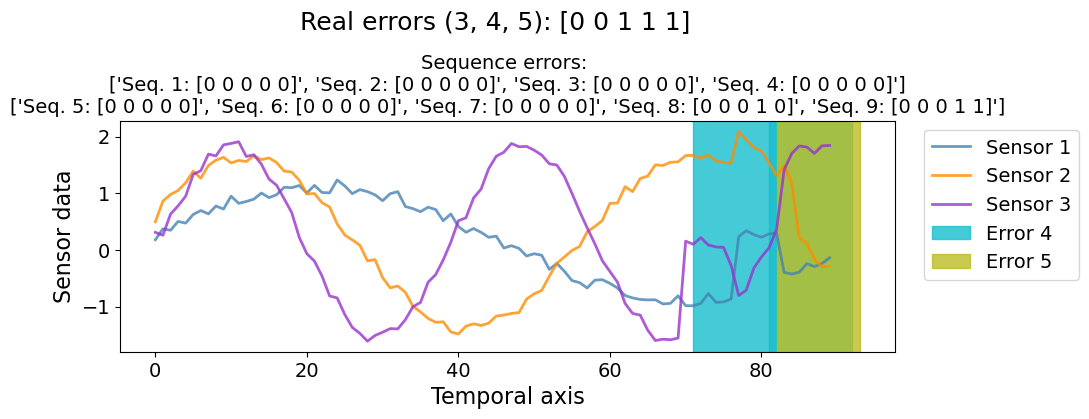

1/1 [==============================] - 0s 26ms/step


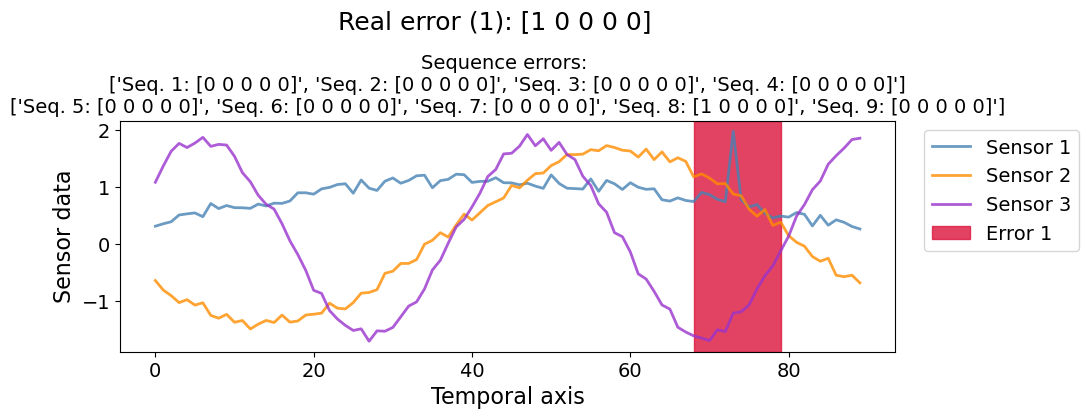

1/1 [==============================] - 0s 62ms/step


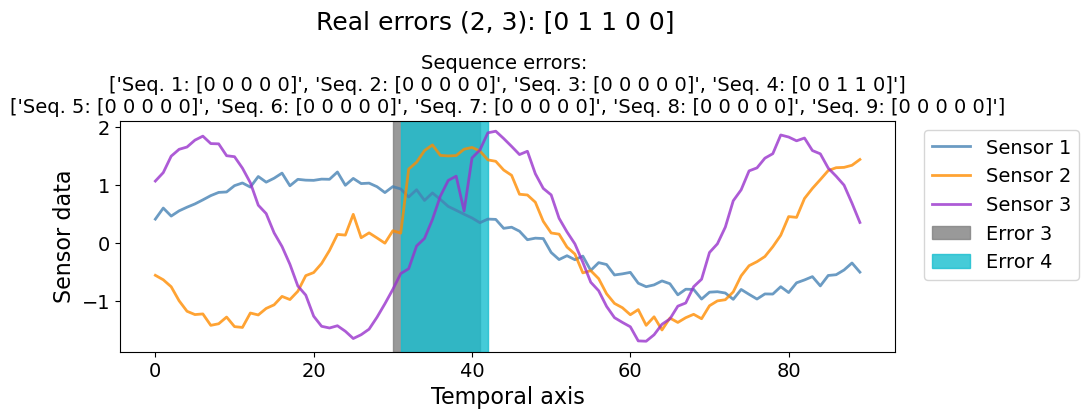

1/1 [==============================] - 0s 26ms/step


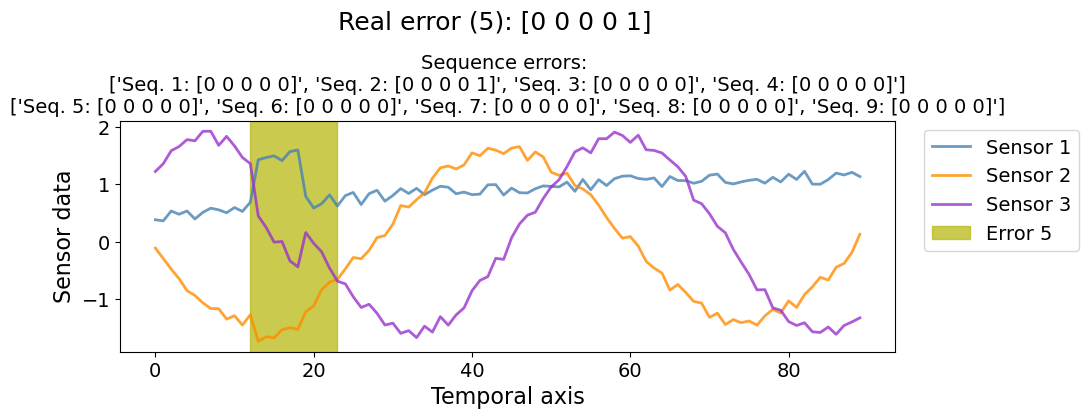

1/1 [==============================] - 0s 27ms/step


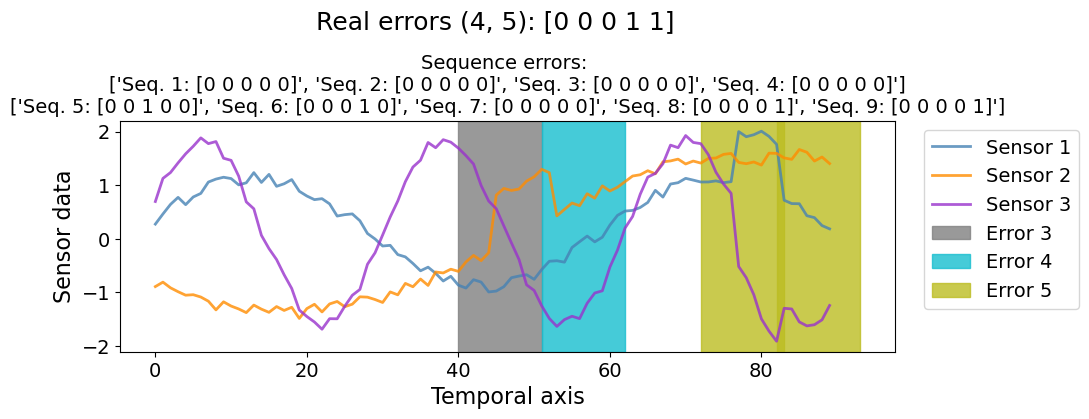

1/1 [==============================] - 0s 29ms/step


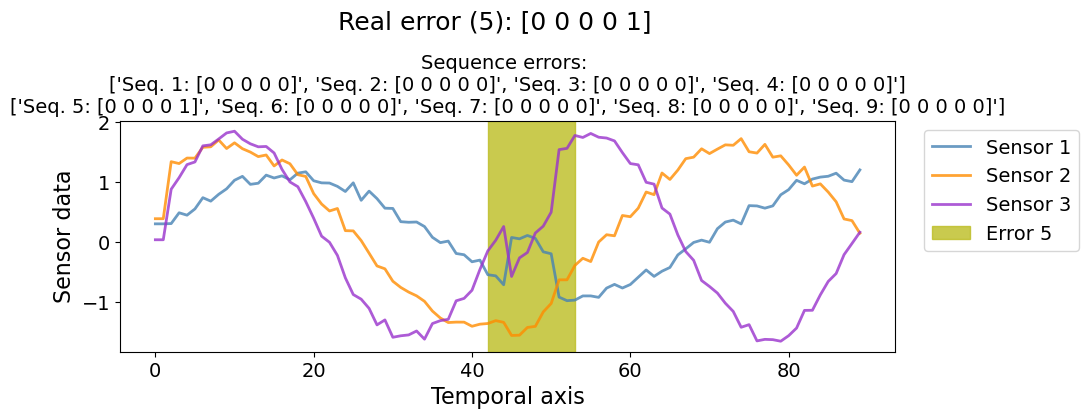

1/1 [==============================] - 0s 25ms/step


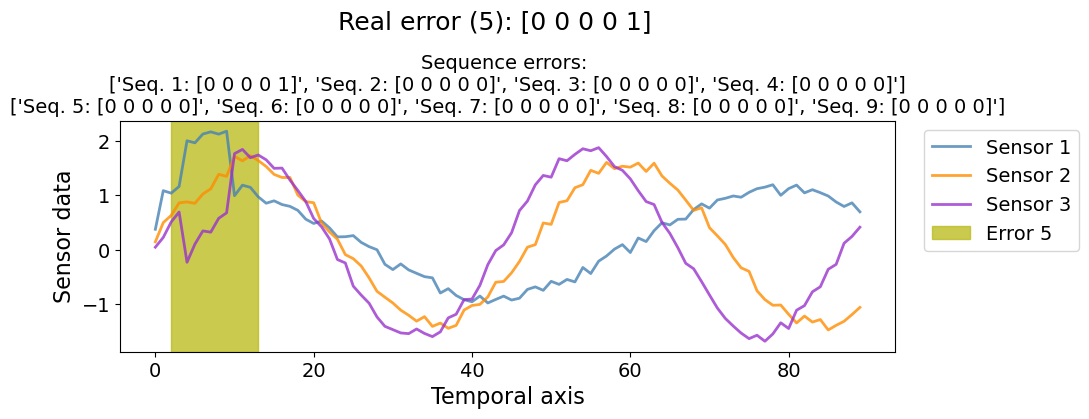

In [227]:
plot_n_error_subsequence(X=X_test, y=y_test, model=loc_model, n_subsequences=9,
									length=10, n_sensors=3, max_fontsize=18,
									figure_size=(10, 3), n_readings=10,
									detection_threshold=0.5)

### Test with detection limit of 0.8

1/1 [==============================] - 0s 30ms/step


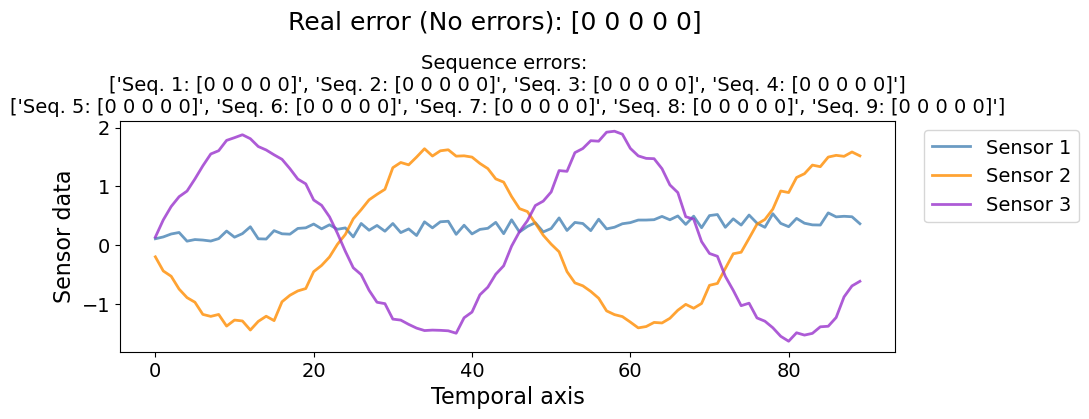

1/1 [==============================] - 0s 23ms/step


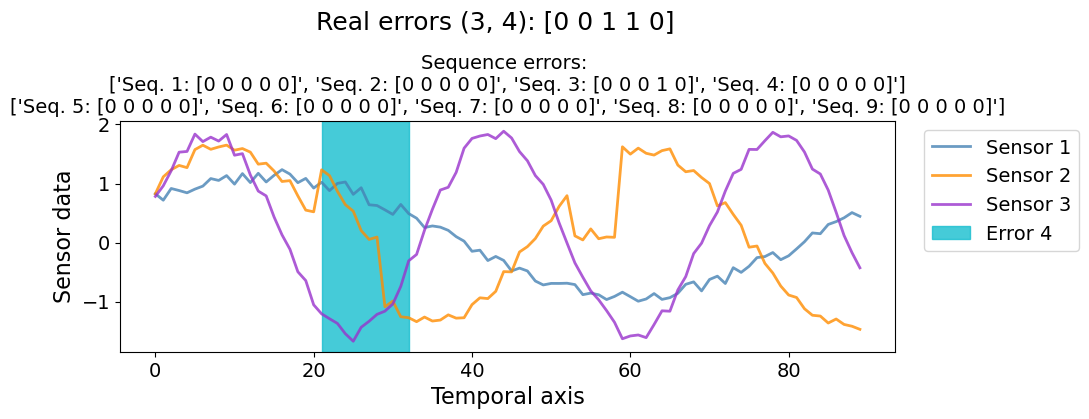

1/1 [==============================] - 0s 26ms/step


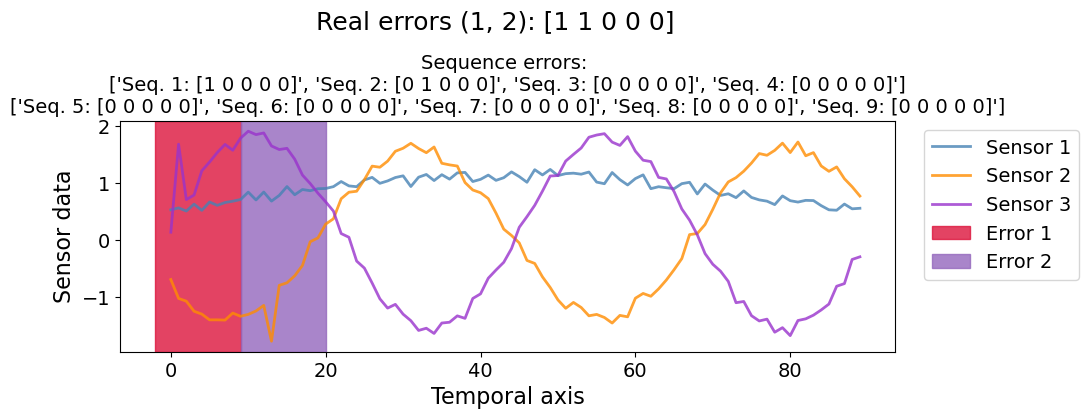

1/1 [==============================] - 0s 21ms/step


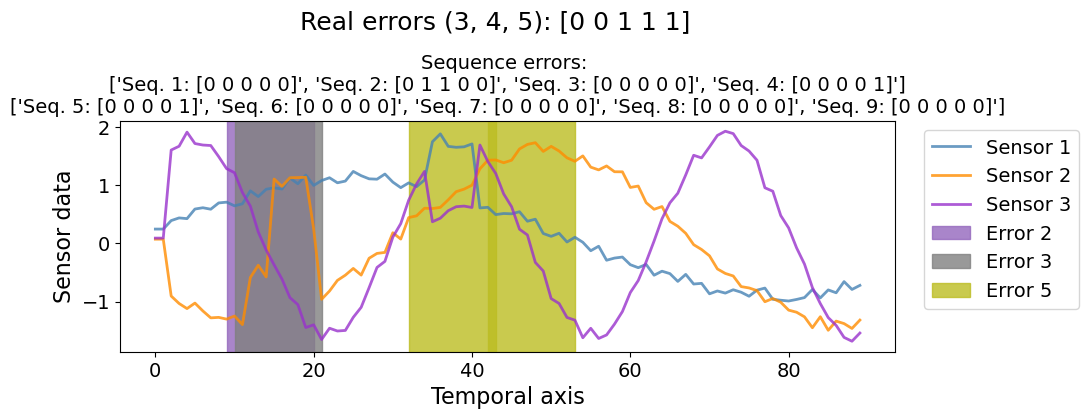

1/1 [==============================] - 0s 27ms/step


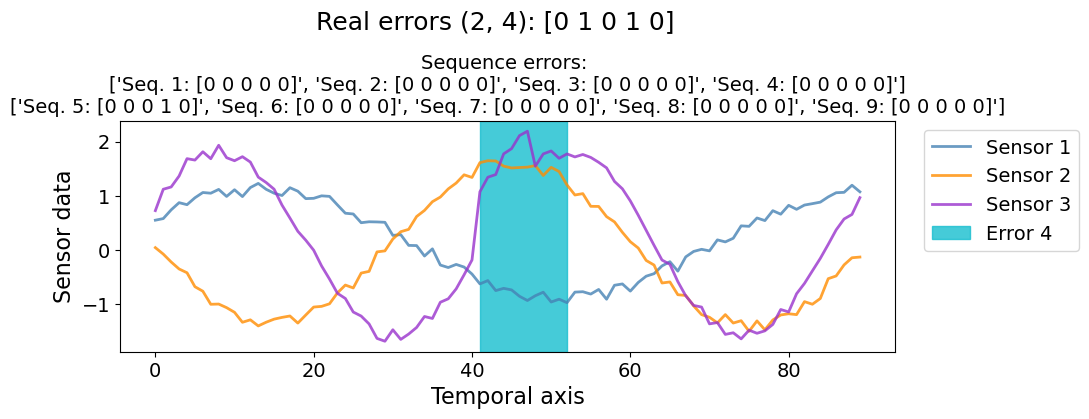

1/1 [==============================] - 0s 23ms/step


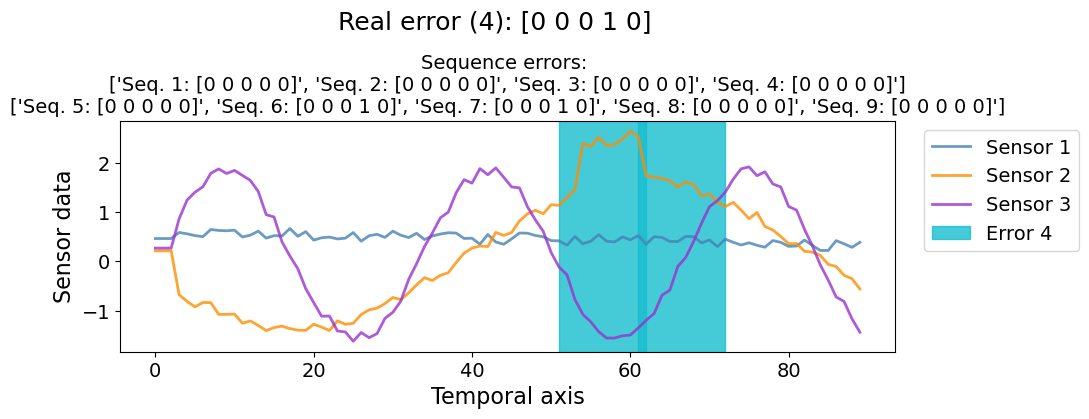

1/1 [==============================] - 0s 23ms/step


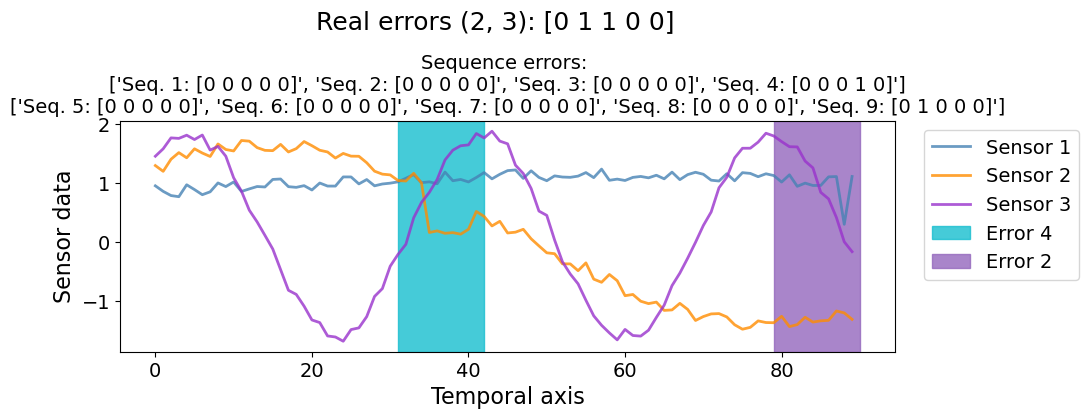

1/1 [==============================] - 0s 27ms/step


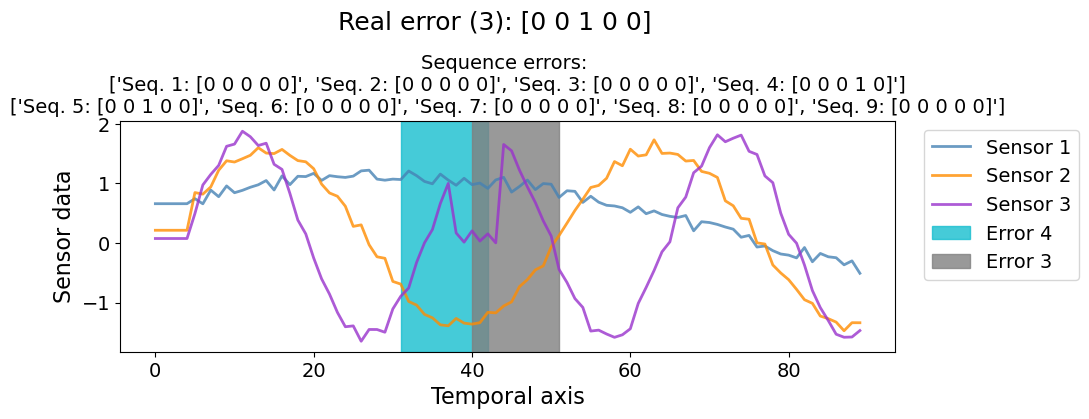

1/1 [==============================] - 0s 23ms/step


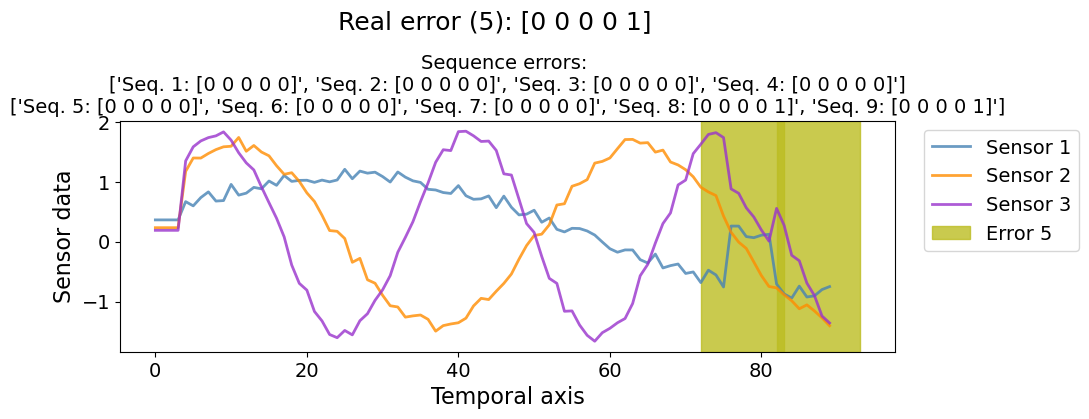

1/1 [==============================] - 0s 24ms/step


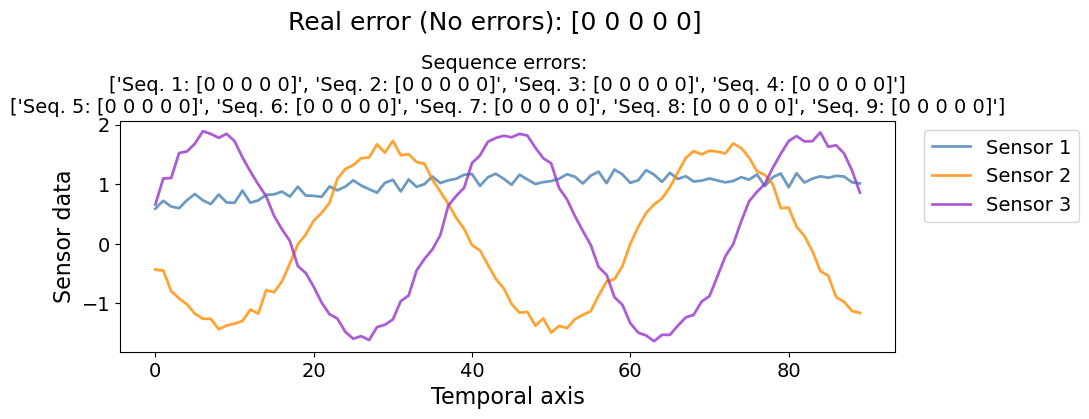

In [228]:
plot_n_error_subsequence(X=X_test, y=y_test, model=loc_model, n_subsequences=9,
									length=10, n_sensors=3, max_fontsize=18,
									figure_size=(10, 3), n_readings=10,
									detection_threshold=0.8)

<p><strong>Comments:</strong></p>

<p>The created function is able to correctly identify sensor errors, showing the indices where the real error is located, the array of the real error and presenting a list with the sequences. It also presents the graph with the three sensor readings for the 10 selected sequences.</p>

<p>Three tests have been performed with different detection limits to see how they affect the detection of errors.</p>

<strong>Test with detection limit of 0.2</strong>

<p>For each graph, it can be seen how the identification of errors with the color bands has been performed correctly in most graphs. It can also be seen how in most cases the errors have a high probability, since the colors of the bands are intense. It is worth noting that a low detection threshold has been set, that is, when performing the transformation to binary value 0 or 1, a value of 0.2 has been used for the threshold. This has been done so that errors can be correctly visualized in some cases (not represented in the current figure) despite the fact that false positives can be detected. </p>

<p>For example, figure 8 contains a real type 4 error, detected in sequence 7. In this case, a type 2 error has also been identified in sequence 8, probably due to the proximity between sequences.</p>

<strong>Test with detection limit of 0.5</strong>

<p>In this second test, most errors have also been correctly detected. However, in Figure 2, we can see how originally there would be errors of type 1, 2, 3 and 5, and the detection system has only detected errors of type 2, 3 and 5. Another example is found in Figure 4 where there should be errors of type 3, 4 and 5, and only types 4 and 5 have been detected. Finally, in Figure 8, we can see how originally there were errors of type 4 and 5, while one of type 3 has also been detected. Here we can clearly see how the higher detection threshold affects the amount of false negatives and positives. The proximity between the errors also has a great influence on detection. That is, the more separated, the easier they are to detect.</p>

<strong>Test with detection limit of 0.8</strong>

<p>In this last test, false negatives are also found in figures 2 and 5, where type 3 and 2 errors have not been detected, respectively. In figures 4 and 7, type 2 and 4 errors have been detected when in reality there should be type 4 and 3 errors, respectively. Finally, in figure 8 a type 4 false negative has been detected.</p>

<p>This indicates that in an error detection system it is necessary to determine the threshold correctly depending on whether false negatives or false positives are prioritized. Thus, it might be better to reduce the threshold to favor error detection, even though non-existent errors are sometimes detected. Finally, it is also important that the errors detected coincide with those originally present, but this also depends on the type of signal being worked with and the location of the error in a subsequence and consequently where the error is cut, that is, if the error is cut in half and is distributed in two subsequences, this could lead to erroneous detection depending on the shape of the signal.</p>

<p>Finally, it should be noted that the error produced by the passage of the subway is error number 5 which corresponds to the color <code>'tab:olive'</code>. The reason why this is so is that when a subway passes near or under a building, the vibrations produced by the movement of the ground will be transmitted to the entire building and, therefore, the sensors will vibrate at the same time. This is what can be seen in the graphs that identify error 5, that is, the simultaneous activation of the sensors. On the other hand, if the building's vibrations are due to other reasons, it is less likely that all the sensors will be activated unless there is an event that causes vibrations in the entire building simultaneously, such as an earthquake.</p>